# Example 12 Singlet fission with bath modes

**This example takes a while. I recommend execution on HPC and select JAX as wrapper**

- References
  - [Chin, Alex W., et al. "Exact mapping between system-reservoir quantum models and semi-infinite discrete chains using orthogonal polynomials." Journal of Mathematical Physics 51.9 (2010).](https://doi.org/10.1063/1.3490188)
  - [Zheng, Jie, et al. "Ultrafast nonadiabatic dynamics of singlet fission: Quantum dynamics with the multilayer multiconfigurational time-dependent Hartree (ML-MCTDH) method." The Journal of Physical Chemistry C 120.3 (2016): 1375-1389.](https://pubs.acs.org/doi/abs/10.1021/acs.jpcc.5b09921)

In [1]:
import platform
import sys

import pytdscf

print(sys.version)
print(f"pytdscf version = {pytdscf.__version__}")
print(platform.platform())

import jax.extend

print(jax.extend.backend.get_backend().platform)

3.12.2 (main, Feb  6 2024, 20:19:44) [Clang 15.0.0 (clang-1500.1.0.2.5)]
pytdscf version = 1.0.3
macOS-14.4.1-arm64-arm-64bit
cpu


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import sympy
from pympo import AssignManager, OpSite, SumOfProducts

from pytdscf import BasInfo, Exciton, Boson, Model, Simulator, units, TensorOperator, TensorHamiltonian

## Model Hamiltonian

$$
H = H_{\text{ele}} + H_{\text{ph}} + H_{\text{el-ph}}
$$

where $H_{\text{ele}}$ is the electronic Hamiltonian consisting of three sites (S1, TT, CS in this order)
and represented by following effective Hamiltonian

$$
H_{\text{ele}} = \begin{pmatrix}
0.2 & 0 & -0.05 \\
0 & 0 & -0.05 \\
-0.05 & -0.05 & 0.3
\end{pmatrix}
$$


and $H_{\text{ph}}$ and $H_{\text{el-ph}}$ are the phonon and electron-phonon coupling Hamiltonians, respectively.

$$
H_{\text{ph}} + H_{\text{el-ph}} 
 = \sum_{k} |k\rangle \langle k| c_0 (b_0 + b_0^\dagger) + \sum_{n=1}^N (\omega_n b_n^\dagger b_n + t_n b_{n+1}^\dagger b_n + t_n b_n^\dagger b_{n+1})
$$

For detail derivation of this reserovir model, please refer to the [reference](https://doi.org/10.1063/1.3490188).

We will set the electronic state as the left terminal site (i=0) and the bath modes as i=1 to N+1 sites.

### Spectral density

The [previous study](https://pubs.acs.org/doi/abs/10.1021/acs.jpcc.5b09921) employed the spectral density defined as Debye type (Lorentzian decaying)
$$
J_{\text{Debye}}(\omega) = \frac{2\lambda \omega \omega_c}{\omega_c^2 + \omega^2}
$$
with a finite cutoff frequency $\omega_c$.

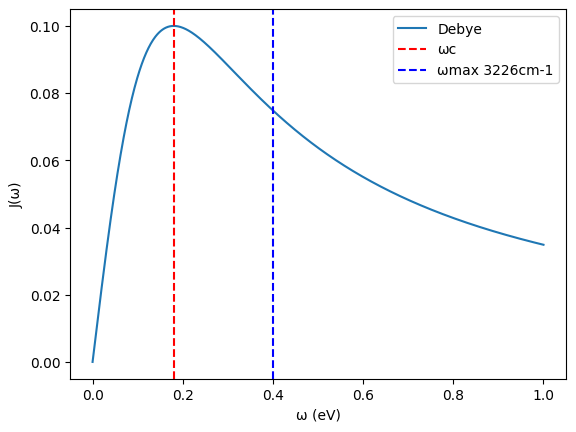

In [3]:
ωc = 0.18  # eV a.k.a charactaristic frequency
λ = 0.10  # eV a.k.a reorganization energy
ωmax = 0.40  # eV cutoff frequency

def J_debye(ω):
    return 2 * λ * ω * ωc / (ω * ω + ωc * ωc)

omega = np.linspace(0.0, 1.0, 1000)
plt.plot(omega, J_debye(omega), label="Debye")
plt.xlabel("ω (eV)")
plt.ylabel("J(ω)")
plt.axvline(x=ωc, color="red", linestyle="--", label="ωc")
plt.axvline(x=ωmax, color="blue", linestyle="--", label="ωmax 3226cm-1")
plt.legend()
plt.show()

The easiest transformation to finite number of harmonic oscillators is just
discretizing integral
$$
\begin{align}
& H_{\text{sys}} + H_{\text{res}} + V
\\
&= 
H_{\text{sys}} 
+ \int_0^{x_{\text{max}}} dx g(x) a_{x} a_{x}^\dagger 
+ \int_0^{x_{\text{max}}} dx h(x) \hat{A} (a_{x} + a_{x}^\dagger)
\\
&\approx
H_{\text{sys}}
+ \sum_{n=1}^N \omega_n a_n^\dagger a_n
+ \sum_{n=1}^N c_n \hat{A} (a_n + a_n^\dagger)
\end{align}
$$
$N$ is usually required to be a hundred number to represent the continuous spectral density.

However, there exists a more sophisticated method to map the continuous spectral density to the discrete chain with nearest neighbor coupling.

## Orthogonal polynomial mapping

We will define spectral density as 
$$
J(\omega) = \frac{2\lambda \frac{\omega}{\omega_c}}{1+\left(\frac{\omega}{\omega_c}\right)^2} \theta\left(\frac{\omega}{\omega_c} - \frac{\omega_{\text{max}}}{\omega_c}\right)
$$
where $\theta(x)$ is the Heaviside step function. 
When we set $g(x) = \omega_c x$ and $x_{\text{max}}=\frac{\omega_{\text{max}}}{\omega_c}$, from the following relation
$$
J(\omega) = \pi h^2\left(\frac{\omega}{\omega_c}\right) \frac{1}{\omega_c},
$$
we can extract constant $C=2\lambda\omega_c / \pi$ and define measure
$$
\mu(x) := \frac{h^2(x)}{C} = \frac{x}{1+x^2} \quad \left(0<x<L=\frac{\omega_{\text{max}}}{\omega_c}\right)
$$
and orthogonal monic polynomials $\{\pi_n\}$ which satisfy
$$
\Braket{\pi_n,\pi_m}_{\mu} = \int_0^L \pi_n(x) \pi_m(x) \mu(x) dx
= \delta_{nm} ||\pi_n||^2
$$
and
$$
\pi_{n+1} = (x-\alpha_n) \pi_n - \beta_n \pi_{n-1}
$$
where $\pi_0 = 1$ and $\pi_{-1} = 0$.

The goal is to find recursion coefficients $\alpha_n$ and $\beta_n$ which satisfy
$$
\alpha_n = \frac{\Braket{x\pi_n, \pi_n}_{\mu}}{\Braket{\pi_n, \pi_n}_{\mu}}
$$
and
$$
\beta_n = \frac{\Braket{\pi_n, \pi_n}_{\mu}}{\Braket{\pi_{n-1}, \pi_{n-1}}_{\mu}}.
$$

First we need to prepare the $k$-th moment of the measure up to $k=2N$.
$$
m_k = \int_0^L x^k \mu(x) dx = 
\int_0^L \frac{x^{k+1}}{1+x^2} dx =
\int_0^{\arctan L} \tan^{k+1}\theta d\theta
$$
$$
m_k = \frac{L^{k}}{k} - m_{k-2}, \quad 
m_0 = -\log(\cos(\arctan(L))) = \frac{1}{2} \log(1+L^2)
, \quad m_1 = L - \arctan L
$$
Then, we determine the coefficients $\alpha_n$ and $\beta_n$ recursively.

Note that recursive calculation tends to accumulate errors, so we will use `mpmath` to calculate the coefficients.

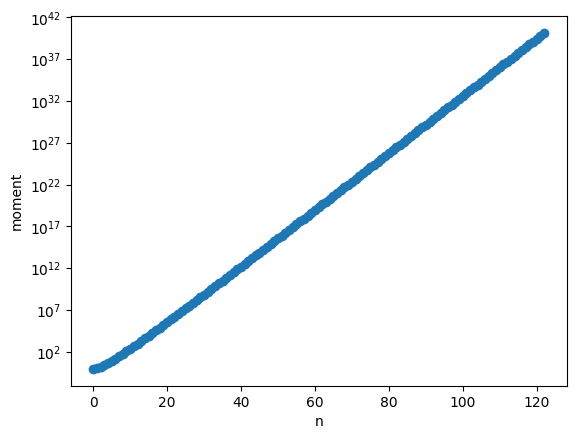

In [4]:
from mpmath import mp, mpf
mp.dps = 512

def get_momments(n_order, L=1.0, factor=1.0): 
    #moments = [mpf(1/2 * math.log(1+L**2)), mpf(L-math.atan(L))]
    moments = [mpf(1) / mpf(2) * mp.log1p(mpf(L) ** 2), mpf(L) - mp.atan(mpf(L))]
    for k in range(2, 2*n_order+1):
        # moments.append(1 / k - moments[-2])
        moments.append(mpf(L) **k / mpf(k) - moments[-2])
    if factor != 1.0:
        factor = mpf(factor)
        moments = [moment * factor ** i for i, moment in enumerate(moments)]
    return moments


n_order = 61
factor = 1.0
L = ωmax / ωc
moments = get_momments(n_order, L, factor)

plt.plot(moments, marker="o")
plt.xlabel("n")
plt.ylabel("moment")
plt.yscale("log")
plt.axhline(0.0, color="black", linestyle="--")
plt.show()

In [5]:
def polynomial_inner_product(poly1: np.ndarray, poly2: np.ndarray, moments: np.ndarray):
    """
    Calculate the inner product of two polynomials using the moments.

    Args:
        poly1: Coefficients of the first polynomial. [1.0, 2.0, 3.0] means 1 + 2x + 3x^2
        poly2: Coefficients of the second polynomial. [1.0, 2.0, 3.0] means 1 + 2x + 3x^2
        moments: Moments used to calculate the inner product.
    """
    assert len(poly1) + len(poly2) - 1 <= len(moments)
    # convolution = np.convolve(poly1, poly2)
    # return np.dot(convolution, moments[:len(convolution)])
    convolution = [mpf(0)] * (len(poly1) + len(poly2) - 1)
    for i in range(len(poly1)):
        for j in range(len(poly2)):
            convolution[i+j] += poly1[i] * poly2[j]
    return sum(c *m for c,m in zip(convolution, moments[:len(convolution)]))


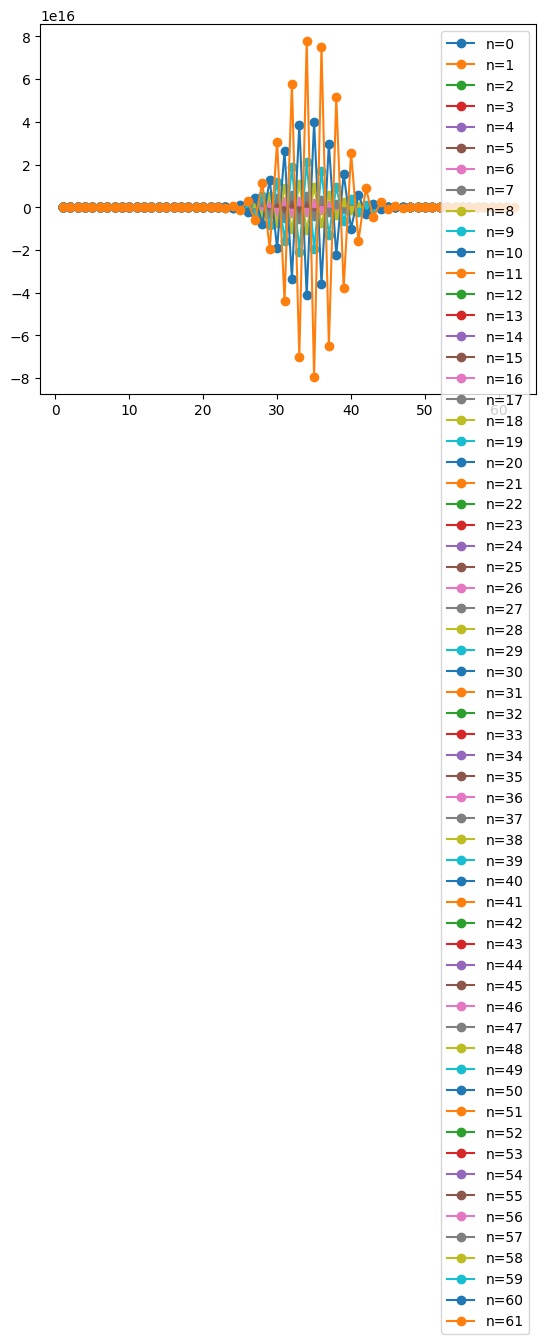

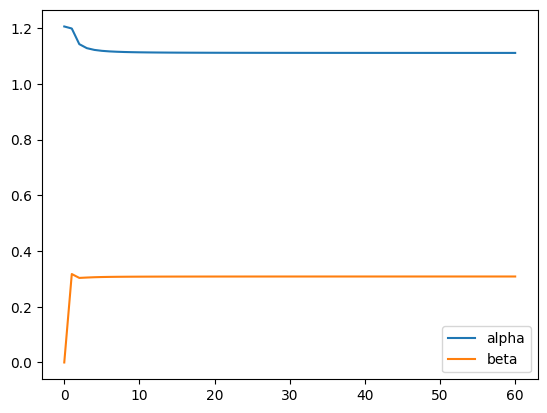

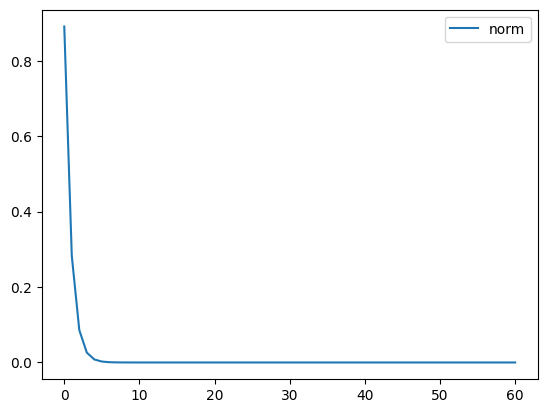

In [6]:

def get_coef_alpha_beta_recursive(n_order, moments):
    # monic_coefs = [[1.0]]
    monic_coefs = [[mpf(1)]]
    alpha = []
    beta = []
    norm = [] # <pi_k,pi_k>
    for n in range(n_order):
        # coefs_pi_k = [0.0] + monic_coefs[-1]
        coefs_pi_k = [mpf(0)] + monic_coefs[-1]
        # coefs_x_pi_k = monic_coefs[-1] + [0.0]
        coefs_x_pi_k = monic_coefs[-1] + [mpf(0)]
        assert coefs_x_pi_k[0] == 1.0
        # <pi_k,pi_k>
        alpha_denom = polynomial_inner_product(np.array(coefs_pi_k)[::-1], np.array(coefs_pi_k)[::-1], np.array(moments))
        # <x pi_k,pi_k>
        alpha_num = polynomial_inner_product(np.array(coefs_x_pi_k)[::-1], np.array(coefs_pi_k)[::-1], np.array(moments))
        alpha.append(alpha_num / alpha_denom)
        norm.append(alpha_denom)
        if n >= 1:
            beta_num = norm[-1]
            beta_denom = norm[-2]
            beta.append(beta_num / beta_denom)
        else:
            # beta.append(0.0)
            beta.append(mpf(0))
        monic_coefs.append(coefs_x_pi_k)
        for i in range(len(monic_coefs[-2])):
            monic_coefs[-1][-i-1] -= alpha[-1] * monic_coefs[-2][-i-1]
        if n >= 1:
            for i in range(len(monic_coefs[-3])):
                monic_coefs[-1][-i-1] -= beta[-1] * monic_coefs[-3][-i-1]
    return monic_coefs, alpha, beta, norm

monic_coefs, alpha, beta, norm = get_coef_alpha_beta_recursive(n_order, moments)

# monic_coefをすべてplot (足りない部分は0)
for i in range(len(monic_coefs)):
    plt.plot(np.arange(i+1, 0, -1), monic_coefs[i], label=f"n={i}", marker="o")
plt.legend()
plt.show()

plt.plot(alpha, label="alpha")
plt.plot(beta, label="beta")
plt.legend()
plt.show()

plt.plot(norm, label="norm")
plt.legend()
plt.show()

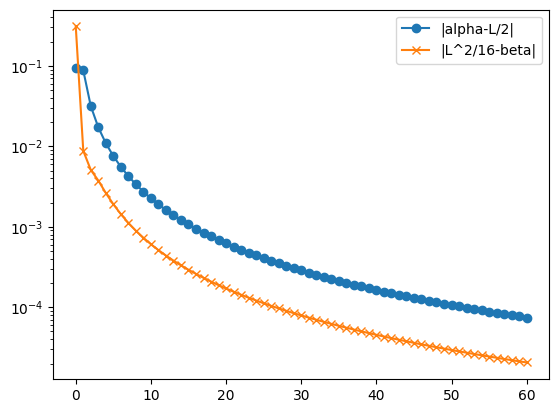

In [7]:
plt.plot(np.abs(np.array(alpha)-L/2), label="|alpha-L/2|", marker="o")
plt.plot(np.abs(L**2/16-np.array(beta)), label="|L^2/16-beta|", marker="x")
plt.yscale("log")
plt.legend()
plt.show()

Then, we have the parameters

$$
c_0 = |\pi_0| = \sqrt{m_0} = \sqrt{\frac{1}{2} \log(1+L^2)}
$$
$$
\omega_n = \omega_c \alpha_n
$$
$$
t_n = \omega_c \sqrt{\beta_{n+1}}
$$

And total Hamiltonian is
$$
H_{\text{sys}} + \sqrt{\frac{\lambda\omega_c\log(1+L^2)}{\pi}} \hat{A} (b_0 + b_0^\dagger) + \sum_{n=0}^N \omega_c(\alpha_n b_n^\dagger b_n + \sqrt{\beta_{n+1}} b_{n+1}^\dagger b_n + \sqrt{\beta_{n+1}} b_n^\dagger b_{n+1})
$$
where $\hat{A}$ is the operator like $\sum_{k} |k\rangle \langle k|$ acting on the electronic state.

In [8]:
backend = "jax"
c0 = math.sqrt(λ*ωc*math.log(1+L**2) / math.pi) /  units.au_in_eV
omega = np.array(alpha, dtype=np.float64) * ωc / units.au_in_eV
t = np.sqrt(np.array(beta[1:], dtype=np.float64)) * ωc / units.au_in_eV

c0_sym = sympy.Symbol('c_0')
omega_syms = [sympy.Symbol(f'omega_{i}') for i in range(len(omega))]
t_syms = [sympy.Symbol(f't_{i}') for i in range(len(t))]

subs = {}
subs[c0_sym] = c0
for omega_val, omega_sym in zip(omega, omega_syms, strict=True):
    subs[omega_sym] = omega_val
for t_val, t_sym in zip(t, t_syms, strict=True):
    subs[t_sym] = t_val

### Setup basis for wavefunction

In [9]:
basis = [Exciton(nstate=3, names=['S1', 'TT', 'CS'])] + [Boson(8)] * len(omega) * 3
basinfo = BasInfo([basis])
ndim = len(basis)
print(ndim)

184


### Setup one particle operator

In [10]:
eham = np.array([
    [0.2, 0.0, -0.05],
    [0.0, 0.0, -0.05],
    [-0.05, -0.05, 0.3]
]) / units.au_in_eV
#eham -= np.diag([0.5, 0.5, 0.5]) / 3 / units.au_in_eV # Shift trace to be 0
b = basis[1].get_annihilation_matrix()
bdag = basis[1].get_creation_matrix()
num = basis[1].get_number_matrix()
bdagb = num
print(bdagb)

ct = np.zeros((3,3))
ct[2,2] = 1.0 # act only on CT

s1 = np.zeros((3,3))
s1[0,0] = 1.0 # act only on S1

tt = np.zeros((3,3))
tt[1,1] = 1.0 # act only on TT

eham_op = OpSite("H_0", 0, value=eham)
ct_op = OpSite("CT_0", 0, value=ct)
s1_op = OpSite("S1_0", 0, value=s1)
tt_op = OpSite("TT_0", 0, value=tt)

b_ops = [None] + [OpSite("b_{" + f"{i}" + "}", i, value=b) for i in range(1, ndim)]
bdag_ops = [None] + [OpSite(r"b^\dagger"+ "_{" + f"{i}" + "}", i, value=bdag) for i in range(1, ndim)]
bdagb_ops = [None] + [OpSite(r"b^\dagger"+ "_{"+ f"{i}" + "}"+"b_{"+f"{i}"+"}", i, value=bdagb) for i in range(1, ndim)]

[[0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0]
 [0 0 0 3 0 0 0 0]
 [0 0 0 0 4 0 0 0]
 [0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 6 0]
 [0 0 0 0 0 0 0 7]]


### Setup potential and kinetic operator

In [11]:
pot_sop = SumOfProducts()

pot_sop += eham_op
pot_sop += c0_sym * s1_op * (b_ops[1] + bdag_ops[1])
pot_sop += c0_sym * tt_op * (b_ops[1+n_order] + bdag_ops[1+n_order])
pot_sop += c0_sym * ct_op * (b_ops[1+2*n_order] + bdag_ops[1+2*n_order])
for i in range(1, 1+n_order):
    for k in range(3):
        shift = n_order * k
        pot_sop += omega_syms[i-1] * bdagb_ops[i+shift]
        if i < n_order:
            pot_sop += t_syms[i-1] * (b_ops[i+shift] * bdag_ops[i+1+shift] + bdag_ops[i+shift] * b_ops[i+1+shift])
        
pot_sop = pot_sop.simplify()
pot_sop.symbol

c_0*CT_0*(b^\dagger_{123} + b_{123}) + c_0*S1_0*(b^\dagger_{1} + b_{1}) + c_0*TT_0*(b^\dagger_{62} + b_{62}) + omega_0*b^\dagger_{123}b_{123} + omega_0*b^\dagger_{1}b_{1} + omega_0*b^\dagger_{62}b_{62} + omega_1*b^\dagger_{124}b_{124} + omega_1*b^\dagger_{2}b_{2} + omega_1*b^\dagger_{63}b_{63} + omega_10*b^\dagger_{11}b_{11} + omega_10*b^\dagger_{133}b_{133} + omega_10*b^\dagger_{72}b_{72} + omega_11*b^\dagger_{12}b_{12} + omega_11*b^\dagger_{134}b_{134} + omega_11*b^\dagger_{73}b_{73} + omega_12*b^\dagger_{135}b_{135} + omega_12*b^\dagger_{13}b_{13} + omega_12*b^\dagger_{74}b_{74} + omega_13*b^\dagger_{136}b_{136} + omega_13*b^\dagger_{14}b_{14} + omega_13*b^\dagger_{75}b_{75} + omega_14*b^\dagger_{137}b_{137} + omega_14*b^\dagger_{15}b_{15} + omega_14*b^\dagger_{76}b_{76} + omega_15*b^\dagger_{138}b_{138} + omega_15*b^\dagger_{16}b_{16} + omega_15*b^\dagger_{77}b_{77} + omega_16*b^\dagger_{139}b_{139} + omega_16*b^\dagger_{17}b_{17} + omega_16*b^\dagger_{78}b_{78} + omega_17*b^\dagge

### Setup MPO

In [12]:
am_pot = AssignManager(pot_sop)
am_pot.assign()
display(*am_pot.Wsym)
W_prod = sympy.Mul(*am_pot.Wsym)
assert W_prod[0] == pot_sop.symbol
print(*[f"W{i}" for i in range(am_pot.ndim)], "=")
display(W_prod[0].expand())
pot_mpo = am_pot.numerical_mpo(subs=subs)

2024-12-13 20:11:09.784 | INFO     | pympo.bipartite:assign:256 - assigned isite=0/184
2024-12-13 20:11:09.905 | INFO     | pympo.bipartite:assign:256 - assigned isite=1/184
2024-12-13 20:11:10.024 | INFO     | pympo.bipartite:assign:256 - assigned isite=2/184
2024-12-13 20:11:10.143 | INFO     | pympo.bipartite:assign:256 - assigned isite=3/184
2024-12-13 20:11:10.261 | INFO     | pympo.bipartite:assign:256 - assigned isite=4/184
2024-12-13 20:11:10.378 | INFO     | pympo.bipartite:assign:256 - assigned isite=5/184
2024-12-13 20:11:10.492 | INFO     | pympo.bipartite:assign:256 - assigned isite=6/184
2024-12-13 20:11:10.606 | INFO     | pympo.bipartite:assign:256 - assigned isite=7/184
2024-12-13 20:11:10.720 | INFO     | pympo.bipartite:assign:256 - assigned isite=8/184
2024-12-13 20:11:10.836 | INFO     | pympo.bipartite:assign:256 - assigned isite=9/184
2024-12-13 20:11:10.957 | INFO     | pympo.bipartite:assign:256 - assigned isite=10/184
2024-12-13 20:11:11.070 | INFO     | pympo

Matrix([[c_0*TT_0, H_0, 1, S1_0, c_0*CT_0]])

Matrix([
[0, 0,                           0,         0, 1,                 0],
[0, 0,                           1,         0, 0,                 0],
[1, 0,  omega_0*b^\dagger_{1}b_{1}, t_0*b_{1}, 0, t_0*b^\dagger_{1}],
[0, 0, c_0*(b^\dagger_{1} + b_{1}),         0, 0,                 0],
[0, 1,                           0,         0, 0,                 0]])

Matrix([
[omega_1*b^\dagger_{2}b_{2}, t_1*b_{2}, b^\dagger_{2}, 1, 0, 0],
[                         0,         0,             0, 0, 0, 1],
[                         1,         0,             0, 0, 0, 0],
[             b^\dagger_{2},         0,             0, 0, 0, 0],
[                         0,         0,             0, 0, 1, 0],
[                     b_{2},         0,             0, 0, 0, 0]])

Matrix([
[            0, 0,                          1,         0, 0, 0],
[            0, 0,              b^\dagger_{3},         0, 0, 0],
[            0, 0,                  t_1*b_{3},         0, 0, 0],
[b^\dagger_{3}, 1, omega_2*b^\dagger_{3}b_{3}, t_2*b_{3}, 0, 0],
[            0, 0,                          0,         0, 1, 0],
[            0, 0,                          0,         0, 0, 1]])

Matrix([
[    0,                  t_2*b_{4}, 0, 0, 0,             0],
[b_{4}, omega_3*b^\dagger_{4}b_{4}, 1, 0, 0, b^\dagger_{4}],
[    0,                          1, 0, 0, 0,             0],
[    0,              b^\dagger_{4}, 0, 0, 0,             0],
[    0,                          0, 0, 1, 0,             0],
[    0,                          0, 0, 0, 1,             0]])

Matrix([
[    0,             0, 0,          t_3*b^\dagger_{5}, 0, 0],
[    0,             0, 0,                          1, 0, 0],
[b_{5}, b^\dagger_{5}, 0, omega_4*b^\dagger_{5}b_{5}, 0, 1],
[    0,             0, 1,                          0, 0, 0],
[    0,             0, 0,                          0, 1, 0],
[    0,             0, 0,                  t_3*b_{5}, 0, 0]])

Matrix([
[                0, 0,     0, 0, 0,          t_4*b^\dagger_{6}],
[                0, 0,     0, 0, 0,                  t_4*b_{6}],
[                0, 0,     0, 1, 0,                          0],
[                0, 0,     0, 0, 0,                          1],
[                0, 1,     0, 0, 0,                          0],
[t_5*b^\dagger_{6}, 0, b_{6}, 0, 1, omega_5*b^\dagger_{6}b_{6}]])

Matrix([
[                0, 0, 0,         0, 0,                      b_{7}],
[                0, 1, 0,         0, 0,                          0],
[                0, 0, 0,         0, 0,          t_5*b^\dagger_{7}],
[                0, 0, 0,         0, 1,                          0],
[t_6*b^\dagger_{7}, 0, 1, t_6*b_{7}, 0, omega_6*b^\dagger_{7}b_{7}],
[                0, 0, 0,         0, 0,                          1]])

Matrix([
[0, 0,             0, 0,                      b_{8},         0],
[0, 1,             0, 0,                          0,         0],
[0, 0, b^\dagger_{8}, 1, omega_7*b^\dagger_{8}b_{8}, t_7*b_{8}],
[0, 0,             0, 0,              b^\dagger_{8},         0],
[1, 0,             0, 0,                          0,         0],
[0, 0,             0, 0,                          1,         0]])

Matrix([
[0, 1,                          0,             0,         0, 0],
[0, 0,                          0,             0,         0, 1],
[0, 0,                  t_7*b_{9},             0,         0, 0],
[1, 0, omega_8*b^\dagger_{9}b_{9}, b^\dagger_{9}, t_8*b_{9}, 0],
[0, 0,                          1,             0,         0, 0],
[0, 0,              b^\dagger_{9},             0,         0, 0]])

Matrix([
[omega_9*b^\dagger_{10}b_{10}, 0, t_9*b^\dagger_{10}, 0, b_{10}, 1],
[                           0, 0,                  0, 1,      0, 0],
[                           1, 0,                  0, 0,      0, 0],
[                  t_8*b_{10}, 0,                  0, 0,      0, 0],
[              b^\dagger_{10}, 0,                  0, 0,      0, 0],
[                           0, 1,                  0, 0,      0, 0]])

Matrix([
[     0, 0, 0,                             1,              0, 0],
[     0, 0, 1,                             0,              0, 0],
[     0, 0, 0,                        b_{11},              0, 0],
[     0, 0, 0,                             0,              0, 1],
[     0, 0, 0,            t_9*b^\dagger_{11},              0, 0],
[b_{11}, 1, 0, omega_10*b^\dagger_{11}b_{11}, b^\dagger_{11}, 0]])

Matrix([
[             0,      0, 0, 0,           t_10*b^\dagger_{12}, 0],
[b^\dagger_{12}, b_{12}, 0, 0, omega_11*b^\dagger_{12}b_{12}, 1],
[             0,      0, 0, 1,                             0, 0],
[             0,      0, 0, 0,                             1, 0],
[             0,      0, 0, 0,                   t_10*b_{12}, 0],
[             0,      0, 1, 0,                             0, 0]])

Matrix([
[     0, 0,                   t_11*b_{13}, 0,              0, 0],
[     0, 0,           t_11*b^\dagger_{13}, 0,              0, 0],
[     0, 1,                             0, 0,              0, 0],
[     0, 0,                             0, 1,              0, 0],
[     0, 0,                             1, 0,              0, 0],
[b_{13}, 0, omega_12*b^\dagger_{13}b_{13}, 0, b^\dagger_{13}, 1]])

Matrix([
[          0,           t_12*b^\dagger_{14}, 0, 0, 0,                   0],
[          0,                             0, 1, 0, 0,                   0],
[          0,                             1, 0, 0, 0,                   0],
[          0,                             0, 0, 0, 1,                   0],
[          0,                   t_12*b_{14}, 0, 0, 0,                   0],
[t_13*b_{14}, omega_13*b^\dagger_{14}b_{14}, 0, 1, 0, t_13*b^\dagger_{14}]])

Matrix([
[     0, 0,              0, 0, 0,                b^\dagger_{15}],
[     0, 0,              0, 0, 0,                             1],
[     0, 1,              0, 0, 0,                             0],
[b_{15}, 0, b^\dagger_{15}, 0, 1, omega_14*b^\dagger_{15}b_{15}],
[     0, 0,              0, 1, 0,                             0],
[     0, 0,              0, 0, 0,                        b_{15}]])

Matrix([
[          t_14*b^\dagger_{16}, 0, 0,      0, 0,                   0],
[                            0, 0, 0,      0, 1,                   0],
[                  t_14*b_{16}, 0, 0,      0, 0,                   0],
[                            0, 1, 0,      0, 0,                   0],
[omega_15*b^\dagger_{16}b_{16}, 0, 1, b_{16}, 0, t_15*b^\dagger_{16}],
[                            1, 0, 0,      0, 0,                   0]])

Matrix([
[                            1, 0,           0, 0, 0,                   0],
[                            0, 0,           0, 1, 0,                   0],
[omega_16*b^\dagger_{17}b_{17}, 0, t_16*b_{17}, 0, 1, t_16*b^\dagger_{17}],
[          t_15*b^\dagger_{17}, 0,           0, 0, 0,                   0],
[                            0, 1,           0, 0, 0,                   0],
[                       b_{17}, 0,           0, 0, 0,                   0]])

Matrix([
[0,                             1, 0, 0,           0,              0],
[0,                             0, 1, 0,           0,              0],
[0,                b^\dagger_{18}, 0, 0,           0,              0],
[0,                             0, 0, 1,           0,              0],
[1, omega_17*b^\dagger_{18}b_{18}, 0, 0, t_17*b_{18}, b^\dagger_{18}],
[0,                        b_{18}, 0, 0,           0,              0]])

Matrix([
[0, 1, omega_18*b^\dagger_{19}b_{19}, t_18*b^\dagger_{19}, 0, b_{19}],
[0, 0,                             1,                   0, 0,      0],
[0, 0,                             0,                   0, 1,      0],
[1, 0,                             0,                   0, 0,      0],
[0, 0,                b^\dagger_{19},                   0, 0,      0],
[0, 0,                   t_17*b_{19},                   0, 0,      0]])

Matrix([
[0, 0,              0,                             0,      0, 1],
[0, 1, b^\dagger_{20}, omega_19*b^\dagger_{20}b_{20}, b_{20}, 0],
[0, 0,              0,                             1,      0, 0],
[0, 0,              0,                        b_{20},      0, 0],
[1, 0,              0,                             0,      0, 0],
[0, 0,              0,           t_18*b^\dagger_{20},      0, 0]])

Matrix([
[                  0, 0,           0, 1, 0,                             0],
[t_20*b^\dagger_{21}, 1, t_20*b_{21}, 0, 0, omega_20*b^\dagger_{21}b_{21}],
[                  0, 0,           0, 0, 0,                   t_19*b_{21}],
[                  0, 0,           0, 0, 0,                             1],
[                  0, 0,           0, 0, 0,           t_19*b^\dagger_{21}],
[                  0, 0,           0, 0, 1,                             0]])

Matrix([
[0,           0, 0,                   0, 0,                        b_{22}],
[0, t_21*b_{22}, 0, t_21*b^\dagger_{22}, 1, omega_21*b^\dagger_{22}b_{22}],
[0,           0, 0,                   0, 0,                b^\dagger_{22}],
[0,           0, 1,                   0, 0,                             0],
[1,           0, 0,                   0, 0,                             0],
[0,           0, 0,                   0, 0,                             1]])

Matrix([
[                            0,              0, 0,      0, 1, 0],
[               b^\dagger_{23},              0, 0,      0, 0, 0],
[                            0,              0, 1,      0, 0, 0],
[                       b_{23},              0, 0,      0, 0, 0],
[omega_22*b^\dagger_{23}b_{23}, b^\dagger_{23}, 0, b_{23}, 0, 1],
[                            1,              0, 0,      0, 0, 0]])

Matrix([
[                  0, 0,                             1, 0,           0, 0],
[                  0, 0,                   t_22*b_{24}, 0,           0, 0],
[                  0, 0,                             0, 1,           0, 0],
[                  0, 0,           t_22*b^\dagger_{24}, 0,           0, 0],
[                  0, 1,                             0, 0,           0, 0],
[t_23*b^\dagger_{24}, 0, omega_23*b^\dagger_{24}b_{24}, 0, t_23*b_{24}, 1]])

Matrix([
[0,                        b_{25},           0, 0,                   0, 0],
[0,                             0,           0, 0,                   0, 1],
[0,                             1,           0, 0,                   0, 0],
[0,                             0,           0, 1,                   0, 0],
[0,                b^\dagger_{25},           0, 0,                   0, 0],
[1, omega_24*b^\dagger_{25}b_{25}, t_24*b_{25}, 0, t_24*b^\dagger_{25}, 0]])

Matrix([
[b_{26}, 1, t_25*b^\dagger_{26}, omega_25*b^\dagger_{26}b_{26}, 0, 0],
[     0, 0,                   0,                             1, 0, 0],
[     0, 0,                   0,                b^\dagger_{26}, 0, 0],
[     0, 0,                   0,                             0, 1, 0],
[     0, 0,                   0,                        b_{26}, 0, 0],
[     0, 0,                   0,                             0, 0, 1]])

Matrix([
[0,      0,                   0, 0,           t_25*b^\dagger_{27}, 0],
[1, b_{27}, t_26*b^\dagger_{27}, 0, omega_26*b^\dagger_{27}b_{27}, 0],
[0,      0,                   0, 0,                        b_{27}, 0],
[0,      0,                   0, 0,                             1, 0],
[0,      0,                   0, 1,                             0, 0],
[0,      0,                   0, 0,                             0, 1]])

Matrix([
[b_{28}, 0, omega_27*b^\dagger_{28}b_{28}, 1, t_27*b^\dagger_{28}, 0],
[     0, 0,           t_26*b^\dagger_{28}, 0,                   0, 0],
[     0, 0,                        b_{28}, 0,                   0, 0],
[     0, 1,                             0, 0,                   0, 0],
[     0, 0,                             1, 0,                   0, 0],
[     0, 0,                             0, 0,                   0, 1]])

Matrix([
[0,              0, 0,      0,           t_27*b^\dagger_{29}, 0],
[0,              0, 1,      0,                             0, 0],
[0,              0, 0,      0,                             1, 0],
[0, b^\dagger_{29}, 0, b_{29}, omega_28*b^\dagger_{29}b_{29}, 1],
[0,              0, 0,      0,                        b_{29}, 0],
[1,              0, 0,      0,                             0, 0]])

Matrix([
[          0, 0,              0, 0, 1,                             0],
[          0, 0,              0, 0, 0,                   t_28*b_{30}],
[          0, 0,              0, 1, 0,                             0],
[          0, 0,              0, 0, 0,           t_28*b^\dagger_{30}],
[          0, 0,              0, 0, 0,                             1],
[t_29*b_{30}, 1, b^\dagger_{30}, 0, 0, omega_29*b^\dagger_{30}b_{30}]])

Matrix([
[                  0,                b^\dagger_{31},           0, 0, 0, 0],
[t_30*b^\dagger_{31}, omega_30*b^\dagger_{31}b_{31}, t_30*b_{31}, 1, 0, 0],
[                  0,                   t_29*b_{31},           0, 0, 0, 0],
[                  0,                             0,           0, 0, 1, 0],
[                  0,                             0,           0, 0, 0, 1],
[                  0,                             1,           0, 0, 0, 0]])

Matrix([
[0,           0,                        b_{32}, 0,                   0, 0],
[0,           0,                             1, 0,                   0, 0],
[0,           0,                b^\dagger_{32}, 0,                   0, 0],
[1, t_31*b_{32}, omega_31*b^\dagger_{32}b_{32}, 0, t_31*b^\dagger_{32}, 0],
[0,           0,                             0, 1,                   0, 0],
[0,           0,                             0, 0,                   0, 1]])

Matrix([
[t_32*b_{33}, 0, omega_32*b^\dagger_{33}b_{33}, 1, 0, b^\dagger_{33}],
[          0, 0,                b^\dagger_{33}, 0, 0,              0],
[          0, 0,                             1, 0, 0,              0],
[          0, 0,                             0, 0, 1,              0],
[          0, 0,                        b_{33}, 0, 0,              0],
[          0, 1,                             0, 0, 0,              0]])

Matrix([
[0, 0,                b^\dagger_{34}, 0,                   0,      0],
[1, 0,                             0, 0,                   0,      0],
[0, 0,                             1, 0,                   0,      0],
[0, 1, omega_33*b^\dagger_{34}b_{34}, 0, t_33*b^\dagger_{34}, b_{34}],
[0, 0,                             0, 1,                   0,      0],
[0, 0,                   t_32*b_{34}, 0,                   0,      0]])

Matrix([
[0, 0,                   0,                             0, 1,      0],
[1, 0, t_34*b^\dagger_{35}, omega_34*b^\dagger_{35}b_{35}, 0, b_{35}],
[0, 0,                   0,                             1, 0,      0],
[0, 1,                   0,                             0, 0,      0],
[0, 0,                   0,                        b_{35}, 0,      0],
[0, 0,                   0,           t_33*b^\dagger_{35}, 0,      0]])

Matrix([
[t_35*b^\dagger_{36}, 1, t_35*b_{36}, 0, omega_35*b^\dagger_{36}b_{36}, 0],
[                  0, 0,           0, 1,                             0, 0],
[                  0, 0,           0, 0,                        b_{36}, 0],
[                  0, 0,           0, 0,                             1, 0],
[                  0, 0,           0, 0,                             0, 1],
[                  0, 0,           0, 0,           t_34*b^\dagger_{36}, 0]])

Matrix([
[0, 0,           0, 0,                   0,                        b_{37}],
[0, 1, t_36*b_{37}, 0, t_36*b^\dagger_{37}, omega_36*b^\dagger_{37}b_{37}],
[0, 0,           0, 0,                   0,                b^\dagger_{37}],
[0, 0,           0, 1,                   0,                             0],
[0, 0,           0, 0,                   0,                             1],
[1, 0,           0, 0,                   0,                             0]])

Matrix([
[             0, 0,                             0, 0,           0, 1],
[b^\dagger_{38}, 1, omega_37*b^\dagger_{38}b_{38}, 0, t_37*b_{38}, 0],
[             0, 0,                b^\dagger_{38}, 0,           0, 0],
[             0, 0,                             0, 1,           0, 0],
[             0, 0,                        b_{38}, 0,           0, 0],
[             0, 0,                             1, 0,           0, 0]])

Matrix([
[0, 0, 0,              0,           0,                   t_37*b_{39}],
[0, 0, 1, b^\dagger_{39}, t_38*b_{39}, omega_38*b^\dagger_{39}b_{39}],
[0, 0, 0,              0,           0,                             1],
[1, 0, 0,              0,           0,                             0],
[0, 0, 0,              0,           0,                b^\dagger_{39}],
[0, 1, 0,              0,           0,                             0]])

Matrix([
[     0,                   0, 1, 0, 0,                             0],
[     0,                   0, 0, 0, 1,                             0],
[b_{40}, t_39*b^\dagger_{40}, 0, 1, 0, omega_39*b^\dagger_{40}b_{40}],
[     0,                   0, 0, 0, 0,                   t_38*b_{40}],
[     0,                   0, 0, 0, 0,                b^\dagger_{40}],
[     0,                   0, 0, 0, 0,                             1]])

Matrix([
[     0,                   0, 0,           t_39*b^\dagger_{41}, 0, 0],
[     0,                   0, 0,                        b_{41}, 0, 0],
[     0,                   0, 1,                             0, 0, 0],
[b_{41}, t_40*b^\dagger_{41}, 0, omega_40*b^\dagger_{41}b_{41}, 0, 1],
[     0,                   0, 0,                             0, 1, 0],
[     0,                   0, 0,                             1, 0, 0]])

Matrix([
[          t_40*b^\dagger_{42},      0, 0, 0, 0,                   0],
[                       b_{42},      0, 0, 0, 0,                   0],
[                            0,      0, 0, 1, 0,                   0],
[                            1,      0, 0, 0, 0,                   0],
[                            0,      0, 0, 0, 1,                   0],
[omega_41*b^\dagger_{42}b_{42}, b_{42}, 1, 0, 0, t_41*b^\dagger_{42}]])

Matrix([
[             0, 0, 0,      0, 0,                             1],
[             0, 0, 0,      0, 0,           t_41*b^\dagger_{43}],
[b^\dagger_{43}, 1, 0, b_{43}, 0, omega_42*b^\dagger_{43}b_{43}],
[             0, 0, 1,      0, 0,                             0],
[             0, 0, 0,      0, 1,                             0],
[             0, 0, 0,      0, 0,                        b_{43}]])

Matrix([
[0,           0,                   t_42*b_{44}, 0,              0, 0],
[1, t_43*b_{44}, omega_43*b^\dagger_{44}b_{44}, 0, b^\dagger_{44}, 0],
[0,           0,                             0, 1,              0, 0],
[0,           0,           t_42*b^\dagger_{44}, 0,              0, 0],
[0,           0,                             0, 0,              0, 1],
[0,           0,                             1, 0,              0, 0]])

Matrix([
[0, b_{45}, 0, t_44*b^\dagger_{45}, 1, omega_44*b^\dagger_{45}b_{45}],
[0,      0, 0,                   0, 0,                b^\dagger_{45}],
[0,      0, 0,                   0, 0,                             1],
[0,      0, 1,                   0, 0,                             0],
[0,      0, 0,                   0, 0,                   t_43*b_{45}],
[1,      0, 0,                   0, 0,                             0]])

Matrix([
[                            0,              0, 0, 0,      0, 1],
[          t_44*b^\dagger_{46},              0, 0, 0,      0, 0],
[                            0,              0, 0, 1,      0, 0],
[                       b_{46},              0, 0, 0,      0, 0],
[omega_45*b^\dagger_{46}b_{46}, b^\dagger_{46}, 1, 0, b_{46}, 0],
[                            1,              0, 0, 0,      0, 0]])

Matrix([
[                  0, 0,                             1,      0, 0, 0],
[                  0, 0,                   t_45*b_{47},      0, 0, 0],
[t_46*b^\dagger_{47}, 1, omega_46*b^\dagger_{47}b_{47}, b_{47}, 0, 0],
[                  0, 0,                             0,      0, 1, 0],
[                  0, 0,           t_45*b^\dagger_{47},      0, 0, 0],
[                  0, 0,                             0,      0, 0, 1]])

Matrix([
[             0,      0, 0, 0,                        b_{48}, 0],
[b^\dagger_{48}, b_{48}, 1, 0, omega_47*b^\dagger_{48}b_{48}, 0],
[             0,      0, 0, 0,                             1, 0],
[             0,      0, 0, 0,           t_46*b^\dagger_{48}, 0],
[             0,      0, 0, 1,                             0, 0],
[             0,      0, 0, 0,                             0, 1]])

Matrix([
[0,                   t_47*b_{49}, 0, 0,           0,                   0],
[0,           t_47*b^\dagger_{49}, 0, 0,           0,                   0],
[1, omega_48*b^\dagger_{49}b_{49}, 0, 0, t_48*b_{49}, t_48*b^\dagger_{49}],
[0,                             0, 1, 0,           0,                   0],
[0,                             1, 0, 0,           0,                   0],
[0,                             0, 0, 1,           0,                   0]])

Matrix([
[0, t_49*b^\dagger_{50}, 1, 0, t_49*b_{50}, omega_49*b^\dagger_{50}b_{50}],
[0,                   0, 0, 0,           0,                             1],
[1,                   0, 0, 0,           0,                             0],
[0,                   0, 0, 1,           0,                             0],
[0,                   0, 0, 0,           0,                b^\dagger_{50}],
[0,                   0, 0, 0,           0,                        b_{50}]])

Matrix([
[             0, 1,      0,                             0, 0, 0],
[             0, 0,      0,                        b_{51}, 0, 0],
[b^\dagger_{51}, 0, b_{51}, omega_50*b^\dagger_{51}b_{51}, 1, 0],
[             0, 0,      0,                             0, 0, 1],
[             0, 0,      0,                b^\dagger_{51}, 0, 0],
[             0, 0,      0,                             1, 0, 0]])

Matrix([
[          0,                   0, 0, 0, 0,                   t_50*b_{52}],
[          0,                   0, 0, 1, 0,                             0],
[          0,                   0, 0, 0, 0,           t_50*b^\dagger_{52}],
[          0,                   0, 0, 0, 0,                             1],
[t_51*b_{52}, t_51*b^\dagger_{52}, 1, 0, 0, omega_51*b^\dagger_{52}b_{52}],
[          0,                   0, 0, 0, 1,                             0]])

Matrix([
[               b^\dagger_{53}, 0,           0, 0, 0,              0],
[                       b_{53}, 0,           0, 0, 0,              0],
[omega_52*b^\dagger_{53}b_{53}, 0, t_52*b_{53}, 0, 1, b^\dagger_{53}],
[                            0, 1,           0, 0, 0,              0],
[                            0, 0,           0, 1, 0,              0],
[                            1, 0,           0, 0, 0,              0]])

Matrix([
[     0, 0,                             1, 0,                   0, 0],
[     0, 0,                             0, 1,                   0, 0],
[     0, 0,                b^\dagger_{54}, 0,                   0, 0],
[     0, 0,                             0, 0,                   0, 1],
[b_{54}, 1, omega_53*b^\dagger_{54}b_{54}, 0, t_53*b^\dagger_{54}, 0],
[     0, 0,                   t_52*b_{54}, 0,                   0, 0]])

Matrix([
[0, 0,           0,                   0,           t_53*b^\dagger_{55}, 0],
[0, 0, t_54*b_{55}, t_54*b^\dagger_{55}, omega_54*b^\dagger_{55}b_{55}, 1],
[0, 0,           0,                   0,                             1, 0],
[1, 0,           0,                   0,                             0, 0],
[0, 0,           0,                   0,                        b_{55}, 0],
[0, 1,           0,                   0,                             0, 0]])

Matrix([
[1, 0,                             0, 0,      0,                   0],
[0, 0,                             0, 1,      0,                   0],
[0, 0,                b^\dagger_{56}, 0,      0,                   0],
[0, 0,                        b_{56}, 0,      0,                   0],
[0, 0,                             1, 0,      0,                   0],
[0, 1, omega_55*b^\dagger_{56}b_{56}, 0, b_{56}, t_55*b^\dagger_{56}]])

Matrix([
[1,              0,           0,                             0, 0, 0],
[0, b^\dagger_{57}, t_56*b_{57}, omega_56*b^\dagger_{57}b_{57}, 0, 1],
[0,              0,           0,                             1, 0, 0],
[0,              0,           0,                             0, 1, 0],
[0,              0,           0,           t_55*b^\dagger_{57}, 0, 0],
[0,              0,           0,                        b_{57}, 0, 0]])

Matrix([
[0, 0,              0,      0, 1,                             0],
[0, 0,              0,      0, 0,                   t_56*b_{58}],
[0, 0,              0,      0, 0,                b^\dagger_{58}],
[0, 0,              0,      0, 0,                             1],
[0, 1,              0,      0, 0,                             0],
[1, 0, b^\dagger_{58}, b_{58}, 0, omega_57*b^\dagger_{58}b_{58}]])

Matrix([
[t_58*b^\dagger_{59}, 0, omega_58*b^\dagger_{59}b_{59}, 1, t_58*b_{59}, 0],
[                  0, 1,                             0, 0,           0, 0],
[                  0, 0,                   t_57*b_{59}, 0,           0, 0],
[                  0, 0,           t_57*b^\dagger_{59}, 0,           0, 0],
[                  0, 0,                             0, 0,           0, 1],
[                  0, 0,                             1, 0,           0, 0]])

Matrix([
[                       b_{60}, 0,              0, 0, 0,           0],
[                            0, 0,              0, 0, 1,           0],
[                            1, 0,              0, 0, 0,           0],
[omega_59*b^\dagger_{60}b_{60}, 1, b^\dagger_{60}, 0, 0, t_59*b_{60}],
[               b^\dagger_{60}, 0,              0, 0, 0,           0],
[                            0, 0,              0, 1, 0,           0]])

Matrix([
[0, 0, 0,                             1],
[0, 1, 0, omega_60*b^\dagger_{61}b_{61}],
[0, 0, 0,                   t_59*b_{61}],
[1, 0, 0,                             0],
[0, 0, 1,                             0],
[0, 0, 0,                b^\dagger_{61}]])

Matrix([
[0, 0,      b^\dagger_{62} + b_{62},          0,              0],
[1, 0, omega_0*b^\dagger_{62}b_{62}, t_0*b_{62}, b^\dagger_{62}],
[0, 1,                            0,          0,              0],
[0, 0,                            1,          0,              0]])

Matrix([
[t_1*b_{63}, omega_1*b^\dagger_{63}b_{63}, 1, b^\dagger_{63}, 0],
[         0,                            0, 0,              0, 1],
[         0,                            1, 0,              0, 0],
[         0,               b^\dagger_{63}, 0,              0, 0],
[         0,                   t_0*b_{63}, 0,              0, 0]])

Matrix([
[0,              0,          0, 0,               b^\dagger_{64}],
[0,              0,          0, 0,                            1],
[0, b^\dagger_{64}, t_2*b_{64}, 1, omega_2*b^\dagger_{64}b_{64}],
[0,              0,          0, 0,                   t_1*b_{64}],
[1,              0,          0, 0,                            0]])

Matrix([
[             0, 1,                            0,          0, 0],
[             0, 0,                   t_2*b_{65},          0, 0],
[             0, 0,               b^\dagger_{65},          0, 0],
[b^\dagger_{65}, 0, omega_3*b^\dagger_{65}b_{65}, t_3*b_{65}, 1],
[             0, 0,                            1,          0, 0]])

Matrix([
[0,          0, 0,                   t_3*b_{66},                  0],
[1,          0, 0,                            0,                  0],
[0,          0, 0,                            1,                  0],
[0,          0, 0,               b^\dagger_{66},                  0],
[0, t_4*b_{66}, 1, omega_4*b^\dagger_{66}b_{66}, t_4*b^\dagger_{66}]])

Matrix([
[             0,      0,                            0, 1, 0],
[             0,      0,               b^\dagger_{67}, 0, 0],
[b^\dagger_{67}, b_{67}, omega_5*b^\dagger_{67}b_{67}, 0, 1],
[             0,      0,                            1, 0, 0],
[             0,      0,                       b_{67}, 0, 0]])

Matrix([
[             0,                   t_5*b_{68}, 0,          0, 0],
[             0,           t_5*b^\dagger_{68}, 0,          0, 0],
[             0,                            1, 0,          0, 0],
[             0,                            0, 0,          0, 1],
[b^\dagger_{68}, omega_6*b^\dagger_{68}b_{68}, 1, t_6*b_{68}, 0]])

Matrix([
[                  t_6*b_{69},      0, 0, 0,              0],
[                           1,      0, 0, 0,              0],
[omega_7*b^\dagger_{69}b_{69}, b_{69}, 0, 1, b^\dagger_{69}],
[              b^\dagger_{69},      0, 0, 0,              0],
[                           0,      0, 1, 0,              0]])

Matrix([
[             0, 0,          0, 0,                            1],
[             0, 0,          0, 0,           t_7*b^\dagger_{70}],
[             0, 0,          0, 1,                            0],
[b^\dagger_{70}, 1, t_8*b_{70}, 0, omega_8*b^\dagger_{70}b_{70}],
[             0, 0,          0, 0,                   t_7*b_{70}]])

Matrix([
[0,              0, 0,                   t_8*b_{71},      0],
[1, b^\dagger_{71}, 0, omega_9*b^\dagger_{71}b_{71}, b_{71}],
[0,              0, 0,               b^\dagger_{71},      0],
[0,              0, 1,                            0,      0],
[0,              0, 0,                            1,      0]])

Matrix([
[1, 0, b_{72}, b^\dagger_{72}, omega_10*b^\dagger_{72}b_{72}],
[0, 0,      0,              0,                    t_9*b_{72}],
[0, 1,      0,              0,                             0],
[0, 0,      0,              0,                             1],
[0, 0,      0,              0,            t_9*b^\dagger_{72}]])

Matrix([
[b^\dagger_{73}, 1, omega_11*b^\dagger_{73}b_{73}, t_11*b_{73}, 0],
[             0, 0,                             0,           0, 1],
[             0, 0,           t_10*b^\dagger_{73},           0, 0],
[             0, 0,                   t_10*b_{73},           0, 0],
[             0, 0,                             1,           0, 0]])

Matrix([
[                  t_11*b_{74},              0, 0,      0, 0],
[omega_12*b^\dagger_{74}b_{74}, b^\dagger_{74}, 1, b_{74}, 0],
[                            1,              0, 0,      0, 0],
[               b^\dagger_{74},              0, 0,      0, 0],
[                            0,              0, 0,      0, 1]])

Matrix([
[0, 0,                             1,           0,              0],
[0, 0,                   t_12*b_{75},           0,              0],
[1, 0, omega_13*b^\dagger_{75}b_{75}, t_13*b_{75}, b^\dagger_{75}],
[0, 0,           t_12*b^\dagger_{75},           0,              0],
[0, 1,                             0,           0,              0]])

Matrix([
[t_14*b_{76}, 1, b^\dagger_{76}, 0, omega_14*b^\dagger_{76}b_{76}],
[          0, 0,              0, 1,                             0],
[          0, 0,              0, 0,                             1],
[          0, 0,              0, 0,                b^\dagger_{76}],
[          0, 0,              0, 0,                   t_13*b_{76}]])

Matrix([
[             0, 0,      0, 0,                b^\dagger_{77}],
[b^\dagger_{77}, 1, b_{77}, 0, omega_15*b^\dagger_{77}b_{77}],
[             0, 0,      0, 0,                   t_14*b_{77}],
[             0, 0,      0, 1,                             0],
[             0, 0,      0, 0,                             1]])

Matrix([
[0,           0,                   0,                   t_15*b_{78}, 0],
[0, t_16*b_{78}, t_16*b^\dagger_{78}, omega_16*b^\dagger_{78}b_{78}, 1],
[0,           0,                   0,           t_15*b^\dagger_{78}, 0],
[1,           0,                   0,                             0, 0],
[0,           0,                   0,                             1, 0]])

Matrix([
[             0, 0,                             0, 1,      0],
[             0, 0,                b^\dagger_{79}, 0,      0],
[             0, 0,                        b_{79}, 0,      0],
[             0, 0,                             1, 0,      0],
[b^\dagger_{79}, 1, omega_17*b^\dagger_{79}b_{79}, 0, b_{79}]])

Matrix([
[                  0,                   t_17*b_{80}, 0, 0,      0],
[t_18*b^\dagger_{80}, omega_18*b^\dagger_{80}b_{80}, 1, 0, b_{80}],
[                  0,                             1, 0, 0,      0],
[                  0,                             0, 0, 1,      0],
[                  0,           t_17*b^\dagger_{80}, 0, 0,      0]])

Matrix([
[          0,                        b_{81}, 0,                   0, 0],
[          0,                             1, 0,                   0, 0],
[t_19*b_{81}, omega_19*b^\dagger_{81}b_{81}, 0, t_19*b^\dagger_{81}, 1],
[          0,                             0, 1,                   0, 0],
[          0,           t_18*b^\dagger_{81}, 0,                   0, 0]])

Matrix([
[0,      0,                b^\dagger_{82},                   0, 0],
[0,      0,                             1,                   0, 0],
[1,      0,                             0,                   0, 0],
[0,      0,                        b_{82},                   0, 0],
[0, b_{82}, omega_20*b^\dagger_{82}b_{82}, t_20*b^\dagger_{82}, 1]])

Matrix([
[                  0,           0, 0, 1,                             0],
[                  0,           0, 0, 0,           t_20*b^\dagger_{83}],
[                  0,           0, 0, 0,                             1],
[                  0,           0, 0, 0,                        b_{83}],
[t_21*b^\dagger_{83}, t_21*b_{83}, 1, 0, omega_21*b^\dagger_{83}b_{83}]])

Matrix([
[0, 0,              0,      0,                        b_{84}],
[0, 0,              0,      0,                b^\dagger_{84}],
[0, 1, b^\dagger_{84}, b_{84}, omega_22*b^\dagger_{84}b_{84}],
[1, 0,              0,      0,                             0],
[0, 0,              0,      0,                             1]])

Matrix([
[                  0,           0,                             0, 0, 1],
[t_23*b^\dagger_{85}, t_23*b_{85}, omega_23*b^\dagger_{85}b_{85}, 1, 0],
[                  0,           0,                   t_22*b_{85}, 0, 0],
[                  0,           0,           t_22*b^\dagger_{85}, 0, 0],
[                  0,           0,                             1, 0, 0]])

Matrix([
[0,           0,                        b_{86}, 0,                   0],
[0,           0,                b^\dagger_{86}, 0,                   0],
[0,           0,                             1, 0,                   0],
[0, t_24*b_{86}, omega_24*b^\dagger_{86}b_{86}, 1, t_24*b^\dagger_{86}],
[1,           0,                             0, 0,                   0]])

Matrix([
[          0,              0, 0, 1,                             0],
[          0,              0, 0, 0,                b^\dagger_{87}],
[          0,              0, 0, 0,                             1],
[t_25*b_{87}, b^\dagger_{87}, 1, 0, omega_25*b^\dagger_{87}b_{87}],
[          0,              0, 0, 0,                        b_{87}]])

Matrix([
[             0,                b^\dagger_{88},           0, 0, 0],
[             0,                   t_25*b_{88},           0, 0, 0],
[b^\dagger_{88}, omega_26*b^\dagger_{88}b_{88}, t_26*b_{88}, 1, 0],
[             0,                             0,           0, 0, 1],
[             0,                             1,           0, 0, 0]])

Matrix([
[          0,                   0,                   t_26*b_{89}, 0, 0],
[          0,                   0,                             1, 0, 0],
[          0,                   0,                b^\dagger_{89}, 0, 0],
[t_27*b_{89}, t_27*b^\dagger_{89}, omega_27*b^\dagger_{89}b_{89}, 0, 1],
[          0,                   0,                             0, 1, 0]])

Matrix([
[                  0,           0, 0,                b^\dagger_{90}, 0],
[                  0,           0, 0,                        b_{90}, 0],
[                  0,           0, 0,                             1, 0],
[                  0,           0, 0,                             0, 1],
[t_28*b^\dagger_{90}, t_28*b_{90}, 1, omega_28*b^\dagger_{90}b_{90}, 0]])

Matrix([
[0,                        b_{91},                   0, 0,           0],
[0,                b^\dagger_{91},                   0, 0,           0],
[1, omega_29*b^\dagger_{91}b_{91}, t_29*b^\dagger_{91}, 0, t_29*b_{91}],
[0,                             1,                   0, 0,           0],
[0,                             0,                   0, 1,           0]])

Matrix([
[b_{92}, 0, 1, b^\dagger_{92}, omega_30*b^\dagger_{92}b_{92}],
[     0, 0, 0,              0,                             1],
[     0, 0, 0,              0,                        b_{92}],
[     0, 1, 0,              0,                             0],
[     0, 0, 0,              0,                b^\dagger_{92}]])

Matrix([
[0,           0, 0,           t_30*b^\dagger_{93},                   0],
[1,           0, 0,                             0,                   0],
[0, t_31*b_{93}, 1, omega_31*b^\dagger_{93}b_{93}, t_31*b^\dagger_{93}],
[0,           0, 0,                   t_30*b_{93},                   0],
[0,           0, 0,                             1,                   0]])

Matrix([
[                  0, 1,      0,                             0, 0],
[                  0, 0,      0,                b^\dagger_{94}, 0],
[t_32*b^\dagger_{94}, 0, b_{94}, omega_32*b^\dagger_{94}b_{94}, 1],
[                  0, 0,      0,                             1, 0],
[                  0, 0,      0,                        b_{94}, 0]])

Matrix([
[                  0,                        b_{95}, 0,      0, 0],
[                  0,                             0, 1,      0, 0],
[                  0,           t_32*b^\dagger_{95}, 0,      0, 0],
[                  0,                             1, 0,      0, 0],
[t_33*b^\dagger_{95}, omega_33*b^\dagger_{95}b_{95}, 0, b_{95}, 1]])

Matrix([
[0,      0, 0,              0,                        b_{96}],
[0,      0, 0,              0,                             1],
[1,      0, 0,              0,                             0],
[0,      0, 0,              0,           t_33*b^\dagger_{96}],
[0, b_{96}, 1, b^\dagger_{96}, omega_34*b^\dagger_{96}b_{96}]])

Matrix([
[0,              0,                             0,      0, 1],
[0,              0,           t_34*b^\dagger_{97},      0, 0],
[1, b^\dagger_{97}, omega_35*b^\dagger_{97}b_{97}, b_{97}, 0],
[0,              0,                   t_34*b_{97},      0, 0],
[0,              0,                             1,      0, 0]])

Matrix([
[1, 0, omega_36*b^\dagger_{98}b_{98}, t_36*b_{98}, t_36*b^\dagger_{98}],
[0, 0,                   t_35*b_{98},           0,                   0],
[0, 0,                             1,           0,                   0],
[0, 0,           t_35*b^\dagger_{98},           0,                   0],
[0, 1,                             0,           0,                   0]])

Matrix([
[0, b_{99}, 1, b^\dagger_{99}, omega_37*b^\dagger_{99}b_{99}],
[1,      0, 0,              0,                             0],
[0,      0, 0,              0,                             1],
[0,      0, 0,              0,                b^\dagger_{99}],
[0,      0, 0,              0,                        b_{99}]])

Matrix([
[1,               0,                               0,            0, 0],
[0,               0,            t_37*b^\dagger_{100},            0, 0],
[0, b^\dagger_{100}, omega_38*b^\dagger_{100}b_{100}, t_38*b_{100}, 1],
[0,               0,                    t_37*b_{100},            0, 0],
[0,               0,                               1,            0, 0]])

Matrix([
[1,                               0,               0,       0, 0],
[0,                    t_38*b_{101},               0,       0, 0],
[0,                               1,               0,       0, 0],
[0,                 b^\dagger_{101},               0,       0, 0],
[0, omega_39*b^\dagger_{101}b_{101}, b^\dagger_{101}, b_{101}, 1]])

Matrix([
[              0,                               0, 0, 1,            0],
[              0,                               1, 0, 0,            0],
[              0,                    t_39*b_{102}, 0, 0,            0],
[              0,            t_39*b^\dagger_{102}, 0, 0,            0],
[b^\dagger_{102}, omega_40*b^\dagger_{102}b_{102}, 1, 0, t_40*b_{102}]])

Matrix([
[                   0, 0,                    t_40*b_{103}, 0,       0],
[                   0, 0,                               1, 0,       0],
[t_41*b^\dagger_{103}, 1, omega_41*b^\dagger_{103}b_{103}, 0, b_{103}],
[                   0, 0,                               0, 1,       0],
[                   0, 0,                 b^\dagger_{103}, 0,       0]])

Matrix([
[                        b_{104},       0,                    0, 0, 0],
[omega_42*b^\dagger_{104}b_{104}, b_{104}, t_42*b^\dagger_{104}, 0, 1],
[                              1,       0,                    0, 0, 0],
[                              0,       0,                    0, 1, 0],
[           t_41*b^\dagger_{104},       0,                    0, 0, 0]])

Matrix([
[                              1,                    0, 0,       0, 0],
[           t_42*b^\dagger_{105},                    0, 0,       0, 0],
[                        b_{105},                    0, 0,       0, 0],
[                              0,                    0, 1,       0, 0],
[omega_43*b^\dagger_{105}b_{105}, t_43*b^\dagger_{105}, 0, b_{105}, 1]])

Matrix([
[      0,                    0,                               1, 0, 0],
[      0,                    0,                         b_{106}, 0, 0],
[      0,                    0,                               0, 1, 0],
[      0,                    0,            t_43*b^\dagger_{106}, 0, 0],
[b_{106}, t_44*b^\dagger_{106}, omega_44*b^\dagger_{106}b_{106}, 0, 1]])

Matrix([
[0,       0,               0,            t_44*b^\dagger_{107}, 0],
[0,       0,               0,                         b_{107}, 0],
[0,       0,               0,                               1, 0],
[1,       0,               0,                               0, 0],
[0, b_{107}, b^\dagger_{107}, omega_45*b^\dagger_{107}b_{107}, 1]])

Matrix([
[1, 0,            0,                    0,                               0],
[0, 0,            0,                    0,            t_45*b^\dagger_{108}],
[0, 0,            0,                    0,                    t_45*b_{108}],
[0, 0,            0,                    0,                               1],
[0, 1, t_46*b_{108}, t_46*b^\dagger_{108}, omega_46*b^\dagger_{108}b_{108}]])

Matrix([
[           0,                               0, 1,               0, 0],
[t_47*b_{109}, omega_47*b^\dagger_{109}b_{109}, 0, b^\dagger_{109}, 1],
[           0,                 b^\dagger_{109}, 0,               0, 0],
[           0,                         b_{109}, 0,               0, 0],
[           0,                               1, 0,               0, 0]])

Matrix([
[      0, 0,                 b^\dagger_{110}, 0,                    0],
[      0, 0,                               1, 0,                    0],
[      0, 1,                               0, 0,                    0],
[      0, 0,                    t_47*b_{110}, 0,                    0],
[b_{110}, 0, omega_48*b^\dagger_{110}b_{110}, 1, t_48*b^\dagger_{110}]])

Matrix([
[           0,            t_48*b^\dagger_{111}, 0,                    0, 0],
[           0,                               0, 1,                    0, 0],
[           0,                               1, 0,                    0, 0],
[t_49*b_{111}, omega_49*b^\dagger_{111}b_{111}, 0, t_49*b^\dagger_{111}, 1],
[           0,                         b_{111}, 0,                    0, 0]])

Matrix([
[                b^\dagger_{112}, 0, 0,               0,            0],
[                              1, 0, 0,               0,            0],
[                              0, 1, 0,               0,            0],
[                        b_{112}, 0, 0,               0,            0],
[omega_50*b^\dagger_{112}b_{112}, 0, 1, b^\dagger_{112}, t_50*b_{112}]])

Matrix([
[                              1,       0, 0,               0, 0],
[                              0,       0, 1,               0, 0],
[omega_51*b^\dagger_{113}b_{113}, b_{113}, 0, b^\dagger_{113}, 1],
[                   t_50*b_{113},       0, 0,               0, 0],
[                b^\dagger_{113},       0, 0,               0, 0]])

Matrix([
[                              1,                    0,       0, 0, 0],
[           t_51*b^\dagger_{114},                    0,       0, 0, 0],
[                              0,                    0,       0, 1, 0],
[                   t_51*b_{114},                    0,       0, 0, 0],
[omega_52*b^\dagger_{114}b_{114}, t_52*b^\dagger_{114}, b_{114}, 0, 1]])

Matrix([
[0,            0,                               1, 0,               0],
[0,            0,                         b_{115}, 0,               0],
[0,            0,            t_52*b^\dagger_{115}, 0,               0],
[0,            0,                               0, 1,               0],
[1, t_53*b_{115}, omega_53*b^\dagger_{115}b_{115}, 0, b^\dagger_{115}]])

Matrix([
[t_54*b_{116}, omega_54*b^\dagger_{116}b_{116}, b^\dagger_{116}, 0, 1],
[           0,                 b^\dagger_{116},               0, 0, 0],
[           0,                               1,               0, 0, 0],
[           0,                               0,               0, 1, 0],
[           0,                    t_53*b_{116},               0, 0, 0]])

Matrix([
[           0,                 b^\dagger_{117}, 0, 0,                    0],
[           0,                               1, 0, 0,                    0],
[           0,                    t_54*b_{117}, 0, 0,                    0],
[           0,                               0, 0, 1,                    0],
[t_55*b_{117}, omega_55*b^\dagger_{117}b_{117}, 1, 0, t_55*b^\dagger_{117}]])

Matrix([
[      0, 0,                    0, 0,                 b^\dagger_{118}],
[      0, 0,                    0, 0,                               1],
[b_{118}, 1, t_56*b^\dagger_{118}, 0, omega_56*b^\dagger_{118}b_{118}],
[      0, 0,                    0, 1,                               0],
[      0, 0,                    0, 0,                         b_{118}]])

Matrix([
[           0,               0,            t_56*b^\dagger_{119}, 0, 0],
[t_57*b_{119}, b^\dagger_{119}, omega_57*b^\dagger_{119}b_{119}, 0, 1],
[           0,               0,                         b_{119}, 0, 0],
[           0,               0,                               0, 1, 0],
[           0,               0,                               1, 0, 0]])

Matrix([
[              0,       0, 0, 0,                 b^\dagger_{120}],
[              0,       0, 0, 0,                    t_57*b_{120}],
[              0,       0, 0, 0,                               1],
[              0,       0, 1, 0,                               0],
[b^\dagger_{120}, b_{120}, 0, 1, omega_58*b^\dagger_{120}b_{120}]])

Matrix([
[                   0,                    t_58*b_{121}, 0,       0, 0],
[                   0,            t_58*b^\dagger_{121}, 0,       0, 0],
[                   0,                               0, 0,       0, 1],
[t_59*b^\dagger_{121}, omega_59*b^\dagger_{121}b_{121}, 1, b_{121}, 0],
[                   0,                               1, 0,       0, 0]])

Matrix([
[                        b_{122}, 0, 0],
[                              1, 0, 0],
[omega_60*b^\dagger_{122}b_{122}, 0, 1],
[           t_59*b^\dagger_{122}, 0, 0],
[                              0, 1, 0]])

Matrix([
[              0,                              1,           0, 0],
[              0,      b^\dagger_{123} + b_{123},           0, 0],
[b^\dagger_{123}, omega_0*b^\dagger_{123}b_{123}, t_0*b_{123}, 1]])

Matrix([
[                   t_0*b_{124}, 0,                   0,       0],
[                             1, 0,                   0,       0],
[               b^\dagger_{124}, 0,                   0,       0],
[omega_1*b^\dagger_{124}b_{124}, 1, t_1*b^\dagger_{124}, b_{124}]])

Matrix([
[0,                              1,           0,                   0],
[1, omega_2*b^\dagger_{125}b_{125}, t_2*b_{125}, t_2*b^\dagger_{125}],
[0,                        b_{125},           0,                   0],
[0,            t_1*b^\dagger_{125},           0,                   0]])

Matrix([
[t_3*b^\dagger_{126}, omega_3*b^\dagger_{126}b_{126}, 1, t_3*b_{126}],
[                  0,                              1, 0,           0],
[                  0,                b^\dagger_{126}, 0,           0],
[                  0,                        b_{126}, 0,           0]])

Matrix([
[                       b_{127},               0,       0, 0],
[                             1,               0,       0, 0],
[omega_4*b^\dagger_{127}b_{127}, b^\dagger_{127}, b_{127}, 1],
[               b^\dagger_{127},               0,       0, 0]])

Matrix([
[                             1,               0,       0, 0],
[                   t_4*b_{128},               0,       0, 0],
[           t_4*b^\dagger_{128},               0,       0, 0],
[omega_5*b^\dagger_{128}b_{128}, b^\dagger_{128}, b_{128}, 1]])

Matrix([
[0,       0,                   0,                              1],
[0,       0,                   0,                    t_5*b_{129}],
[0,       0,                   0,            t_5*b^\dagger_{129}],
[1, b_{129}, t_6*b^\dagger_{129}, omega_6*b^\dagger_{129}b_{129}]])

Matrix([
[omega_7*b^\dagger_{130}b_{130}, 1, b_{130}, t_7*b^\dagger_{130}],
[           t_6*b^\dagger_{130}, 0,       0,                   0],
[                       b_{130}, 0,       0,                   0],
[                             1, 0,       0,                   0]])

Matrix([
[          0,                              1, 0,                   0],
[t_8*b_{131}, omega_8*b^\dagger_{131}b_{131}, 1, t_8*b^\dagger_{131}],
[          0,            t_7*b^\dagger_{131}, 0,                   0],
[          0,                        b_{131}, 0,                   0]])

Matrix([
[          0, 0,                   0,                b^\dagger_{132}],
[          0, 0,                   0,                              1],
[t_9*b_{132}, 1, t_9*b^\dagger_{132}, omega_9*b^\dagger_{132}b_{132}],
[          0, 0,                   0,                        b_{132}]])

Matrix([
[0,                    0,       0,                 b^\dagger_{133}],
[1, t_10*b^\dagger_{133}, b_{133}, omega_10*b^\dagger_{133}b_{133}],
[0,                    0,       0,                         b_{133}],
[0,                    0,       0,                               1]])

Matrix([
[b^\dagger_{134}, t_11*b_{134}, 1, omega_11*b^\dagger_{134}b_{134}],
[              0,            0, 0,                         b_{134}],
[              0,            0, 0,            t_10*b^\dagger_{134}],
[              0,            0, 0,                               1]])

Matrix([
[                   0,                    t_11*b_{135}, 0,       0],
[                   0,                 b^\dagger_{135}, 0,       0],
[t_12*b^\dagger_{135}, omega_12*b^\dagger_{135}b_{135}, 1, b_{135}],
[                   0,                               1, 0,       0]])

Matrix([
[0,               0,                         b_{136},            0],
[0,               0,                               1,            0],
[1, b^\dagger_{136}, omega_13*b^\dagger_{136}b_{136}, t_13*b_{136}],
[0,               0,            t_12*b^\dagger_{136},            0]])

Matrix([
[b^\dagger_{137}, t_14*b_{137}, omega_14*b^\dagger_{137}b_{137}, 1],
[              0,            0,                    t_13*b_{137}, 0],
[              0,            0,                               1, 0],
[              0,            0,                 b^\dagger_{137}, 0]])

Matrix([
[                   0,                    t_14*b_{138},            0, 0],
[                   0,                 b^\dagger_{138},            0, 0],
[                   0,                               1,            0, 0],
[t_15*b^\dagger_{138}, omega_15*b^\dagger_{138}b_{138}, t_15*b_{138}, 1]])

Matrix([
[           0, 0,                         b_{139},               0],
[           0, 0,                               1,               0],
[           0, 0,                 b^\dagger_{139},               0],
[t_16*b_{139}, 1, omega_16*b^\dagger_{139}b_{139}, b^\dagger_{139}]])

Matrix([
[                b^\dagger_{140},       0,               0, 0],
[omega_17*b^\dagger_{140}b_{140}, b_{140}, b^\dagger_{140}, 1],
[                              1,       0,               0, 0],
[                   t_16*b_{140},       0,               0, 0]])

Matrix([
[           0,                    0,                               1, 0],
[           0,                    0,            t_17*b^\dagger_{141}, 0],
[           0,                    0,                    t_17*b_{141}, 0],
[t_18*b_{141}, t_18*b^\dagger_{141}, omega_18*b^\dagger_{141}b_{141}, 1]])

Matrix([
[                b^\dagger_{142}, 0,       0,                    0],
[                        b_{142}, 0,       0,                    0],
[                              1, 0,       0,                    0],
[omega_19*b^\dagger_{142}b_{142}, 1, b_{142}, t_19*b^\dagger_{142}]])

Matrix([
[           0,                    0, 0,                               1],
[t_20*b_{143}, t_20*b^\dagger_{143}, 1, omega_20*b^\dagger_{143}b_{143}],
[           0,                    0, 0,            t_19*b^\dagger_{143}],
[           0,                    0, 0,                         b_{143}]])

Matrix([
[              0,                 b^\dagger_{144},       0, 0],
[              0,                         b_{144},       0, 0],
[b^\dagger_{144}, omega_21*b^\dagger_{144}b_{144}, b_{144}, 1],
[              0,                               1,       0, 0]])

Matrix([
[                   0,            0, 0,                    t_21*b_{145}],
[                   0,            0, 0,                               1],
[                   0,            0, 0,            t_21*b^\dagger_{145}],
[t_22*b^\dagger_{145}, t_22*b_{145}, 1, omega_22*b^\dagger_{145}b_{145}]])

Matrix([
[                        b_{146},       0,               0, 0],
[                b^\dagger_{146},       0,               0, 0],
[omega_23*b^\dagger_{146}b_{146}, b_{146}, b^\dagger_{146}, 1],
[                              1,       0,               0, 0]])

Matrix([
[0,                    0,            0,                               1],
[0,                    0,            0,            t_23*b^\dagger_{147}],
[0,                    0,            0,                    t_23*b_{147}],
[1, t_24*b^\dagger_{147}, t_24*b_{147}, omega_24*b^\dagger_{147}b_{147}]])

Matrix([
[t_25*b_{148}, omega_25*b^\dagger_{148}b_{148}, t_25*b^\dagger_{148}, 1],
[           0,                         b_{148},                    0, 0],
[           0,                 b^\dagger_{148},                    0, 0],
[           0,                               1,                    0, 0]])

Matrix([
[                b^\dagger_{149},               0,            0, 0],
[                              1,               0,            0, 0],
[                        b_{149},               0,            0, 0],
[omega_26*b^\dagger_{149}b_{149}, b^\dagger_{149}, t_26*b_{149}, 1]])

Matrix([
[              0,                               1,            0, 0],
[              0,                    t_26*b_{150},            0, 0],
[              0,                 b^\dagger_{150},            0, 0],
[b^\dagger_{150}, omega_27*b^\dagger_{150}b_{150}, t_27*b_{150}, 1]])

Matrix([
[           0,                    t_27*b_{151}, 0,                    0],
[           0,                               1, 0,                    0],
[           0,                 b^\dagger_{151}, 0,                    0],
[t_28*b_{151}, omega_28*b^\dagger_{151}b_{151}, 1, t_28*b^\dagger_{151}]])

Matrix([
[                b^\dagger_{152},                    0,            0, 0],
[                              1,                    0,            0, 0],
[omega_29*b^\dagger_{152}b_{152}, t_29*b^\dagger_{152}, t_29*b_{152}, 1],
[                        b_{152},                    0,            0, 0]])

Matrix([
[      0,                    0,                               1, 0],
[      0,                    0,                         b_{153}, 0],
[      0,                    0,                 b^\dagger_{153}, 0],
[b_{153}, t_30*b^\dagger_{153}, omega_30*b^\dagger_{153}b_{153}, 1]])

Matrix([
[           0,            t_30*b^\dagger_{154}, 0,               0],
[           0,                         b_{154}, 0,               0],
[           0,                               1, 0,               0],
[t_31*b_{154}, omega_31*b^\dagger_{154}b_{154}, 1, b^\dagger_{154}]])

Matrix([
[                   0, 0,       0,                 b^\dagger_{155}],
[                   0, 0,       0,                               1],
[t_32*b^\dagger_{155}, 1, b_{155}, omega_32*b^\dagger_{155}b_{155}],
[                   0, 0,       0,                    t_31*b_{155}]])

Matrix([
[                        b_{156},       0,                    0, 0],
[omega_33*b^\dagger_{156}b_{156}, b_{156}, t_33*b^\dagger_{156}, 1],
[           t_32*b^\dagger_{156},       0,                    0, 0],
[                              1,       0,                    0, 0]])

Matrix([
[           0,                               1,                    0, 0],
[           0,            t_33*b^\dagger_{157},                    0, 0],
[           0,                         b_{157},                    0, 0],
[t_34*b_{157}, omega_34*b^\dagger_{157}b_{157}, t_34*b^\dagger_{157}, 1]])

Matrix([
[              0, 0,       0,                 b^\dagger_{158}],
[              0, 0,       0,                               1],
[              0, 0,       0,                         b_{158}],
[b^\dagger_{158}, 1, b_{158}, omega_35*b^\dagger_{158}b_{158}]])

Matrix([
[           0,               0, 0,                    t_35*b_{159}],
[t_36*b_{159}, b^\dagger_{159}, 1, omega_36*b^\dagger_{159}b_{159}],
[           0,               0, 0,            t_35*b^\dagger_{159}],
[           0,               0, 0,                               1]])

Matrix([
[           0, 0,                    0,                 b^\dagger_{160}],
[           0, 0,                    0,                    t_36*b_{160}],
[t_37*b_{160}, 1, t_37*b^\dagger_{160}, omega_37*b^\dagger_{160}b_{160}],
[           0, 0,                    0,                               1]])

Matrix([
[                   0,                 b^\dagger_{161},       0, 0],
[t_38*b^\dagger_{161}, omega_38*b^\dagger_{161}b_{161}, b_{161}, 1],
[                   0,                         b_{161},       0, 0],
[                   0,                               1,       0, 0]])

Matrix([
[0,       0,                         b_{162},               0],
[0,       0,                               1,               0],
[0,       0,            t_38*b^\dagger_{162},               0],
[1, b_{162}, omega_39*b^\dagger_{162}b_{162}, b^\dagger_{162}]])

Matrix([
[1, t_40*b^\dagger_{163}, b_{163}, omega_40*b^\dagger_{163}b_{163}],
[0,                    0,       0,            t_39*b^\dagger_{163}],
[0,                    0,       0,                               1],
[0,                    0,       0,                    t_39*b_{163}]])

Matrix([
[omega_41*b^\dagger_{164}b_{164}, 1, b^\dagger_{164}, t_41*b_{164}],
[                        b_{164}, 0,               0,            0],
[           t_40*b^\dagger_{164}, 0,               0,            0],
[                              1, 0,               0,            0]])

Matrix([
[                              1,               0,       0, 0],
[omega_42*b^\dagger_{165}b_{165}, b^\dagger_{165}, b_{165}, 1],
[                   t_41*b_{165},               0,       0, 0],
[                b^\dagger_{165},               0,       0, 0]])

Matrix([
[      0, 0,               0,                               1],
[      0, 0,               0,                    t_42*b_{166}],
[      0, 0,               0,            t_42*b^\dagger_{166}],
[b_{166}, 1, b^\dagger_{166}, omega_43*b^\dagger_{166}b_{166}]])

Matrix([
[      0,            t_43*b^\dagger_{167}, 0,                    0],
[b_{167}, omega_44*b^\dagger_{167}b_{167}, 1, t_44*b^\dagger_{167}],
[      0,                    t_43*b_{167}, 0,                    0],
[      0,                               1, 0,                    0]])

Matrix([
[      0,               0,            t_44*b^\dagger_{168}, 0],
[      0,               0,                               1, 0],
[b_{168}, b^\dagger_{168}, omega_45*b^\dagger_{168}b_{168}, 1],
[      0,               0,                         b_{168}, 0]])

Matrix([
[           0,                    0, 0,            t_45*b^\dagger_{169}],
[           0,                    0, 0,                    t_45*b_{169}],
[           0,                    0, 0,                               1],
[t_46*b_{169}, t_46*b^\dagger_{169}, 1, omega_46*b^\dagger_{169}b_{169}]])

Matrix([
[           0, 0,               0,                 b^\dagger_{170}],
[           0, 0,               0,                         b_{170}],
[t_47*b_{170}, 1, b^\dagger_{170}, omega_47*b^\dagger_{170}b_{170}],
[           0, 0,               0,                               1]])

Matrix([
[                   0,       0,                 b^\dagger_{171}, 0],
[t_48*b^\dagger_{171}, b_{171}, omega_48*b^\dagger_{171}b_{171}, 1],
[                   0,       0,                    t_47*b_{171}, 0],
[                   0,       0,                               1, 0]])

Matrix([
[      0,               0, 0,                         b_{172}],
[      0,               0, 0,            t_48*b^\dagger_{172}],
[      0,               0, 0,                               1],
[b_{172}, b^\dagger_{172}, 1, omega_49*b^\dagger_{172}b_{172}]])

Matrix([
[           t_49*b^\dagger_{173},               0,       0, 0],
[                   t_49*b_{173},               0,       0, 0],
[omega_50*b^\dagger_{173}b_{173}, b^\dagger_{173}, b_{173}, 1],
[                              1,               0,       0, 0]])

Matrix([
[              0,                               1,            0, 0],
[              0,                    t_50*b_{174},            0, 0],
[              0,            t_50*b^\dagger_{174},            0, 0],
[b^\dagger_{174}, omega_51*b^\dagger_{174}b_{174}, t_51*b_{174}, 1]])

Matrix([
[                   0,       0, 0,                    t_51*b_{175}],
[                   0,       0, 0,                               1],
[                   0,       0, 0,                 b^\dagger_{175}],
[t_52*b^\dagger_{175}, b_{175}, 1, omega_52*b^\dagger_{175}b_{175}]])

Matrix([
[           0,                    0,                         b_{176}, 0],
[           0,                    0,            t_52*b^\dagger_{176}, 0],
[t_53*b_{176}, t_53*b^\dagger_{176}, omega_53*b^\dagger_{176}b_{176}, 1],
[           0,                    0,                               1, 0]])

Matrix([
[           0,                    0, 0,                 b^\dagger_{177}],
[           0,                    0, 0,                         b_{177}],
[           0,                    0, 0,                               1],
[t_54*b_{177}, t_54*b^\dagger_{177}, 1, omega_54*b^\dagger_{177}b_{177}]])

Matrix([
[              0,                 b^\dagger_{178},       0, 0],
[              0,                         b_{178},       0, 0],
[b^\dagger_{178}, omega_55*b^\dagger_{178}b_{178}, b_{178}, 1],
[              0,                               1,       0, 0]])

Matrix([
[              0,       0, 0,                    t_55*b_{179}],
[              0,       0, 0,                               1],
[              0,       0, 0,            t_55*b^\dagger_{179}],
[b^\dagger_{179}, b_{179}, 1, omega_56*b^\dagger_{179}b_{179}]])

Matrix([
[                   0,       0,                    t_56*b_{180}, 0],
[                   0,       0,            t_56*b^\dagger_{180}, 0],
[t_57*b^\dagger_{180}, b_{180}, omega_57*b^\dagger_{180}b_{180}, 1],
[                   0,       0,                               1, 0]])

Matrix([
[              0,       0,                         b_{181}, 0],
[              0,       0,            t_57*b^\dagger_{181}, 0],
[              0,       0,                               1, 0],
[b^\dagger_{181}, b_{181}, omega_58*b^\dagger_{181}b_{181}, 1]])

Matrix([
[0,                    t_58*b_{182},            0,                    0],
[0,            t_58*b^\dagger_{182},            0,                    0],
[0,                               1,            0,                    0],
[1, omega_59*b^\dagger_{182}b_{182}, t_59*b_{182}, t_59*b^\dagger_{182}]])

Matrix([
[omega_60*b^\dagger_{183}b_{183}],
[                              1],
[                b^\dagger_{183}],
[                        b_{183}]])

W0 W1 W2 W3 W4 W5 W6 W7 W8 W9 W10 W11 W12 W13 W14 W15 W16 W17 W18 W19 W20 W21 W22 W23 W24 W25 W26 W27 W28 W29 W30 W31 W32 W33 W34 W35 W36 W37 W38 W39 W40 W41 W42 W43 W44 W45 W46 W47 W48 W49 W50 W51 W52 W53 W54 W55 W56 W57 W58 W59 W60 W61 W62 W63 W64 W65 W66 W67 W68 W69 W70 W71 W72 W73 W74 W75 W76 W77 W78 W79 W80 W81 W82 W83 W84 W85 W86 W87 W88 W89 W90 W91 W92 W93 W94 W95 W96 W97 W98 W99 W100 W101 W102 W103 W104 W105 W106 W107 W108 W109 W110 W111 W112 W113 W114 W115 W116 W117 W118 W119 W120 W121 W122 W123 W124 W125 W126 W127 W128 W129 W130 W131 W132 W133 W134 W135 W136 W137 W138 W139 W140 W141 W142 W143 W144 W145 W146 W147 W148 W149 W150 W151 W152 W153 W154 W155 W156 W157 W158 W159 W160 W161 W162 W163 W164 W165 W166 W167 W168 W169 W170 W171 W172 W173 W174 W175 W176 W177 W178 W179 W180 W181 W182 W183 =


c_0*CT_0*b^\dagger_{123} + c_0*CT_0*b_{123} + c_0*S1_0*b^\dagger_{1} + c_0*S1_0*b_{1} + c_0*TT_0*b^\dagger_{62} + c_0*TT_0*b_{62} + omega_0*b^\dagger_{123}b_{123} + omega_0*b^\dagger_{1}b_{1} + omega_0*b^\dagger_{62}b_{62} + omega_1*b^\dagger_{124}b_{124} + omega_1*b^\dagger_{2}b_{2} + omega_1*b^\dagger_{63}b_{63} + omega_10*b^\dagger_{11}b_{11} + omega_10*b^\dagger_{133}b_{133} + omega_10*b^\dagger_{72}b_{72} + omega_11*b^\dagger_{12}b_{12} + omega_11*b^\dagger_{134}b_{134} + omega_11*b^\dagger_{73}b_{73} + omega_12*b^\dagger_{135}b_{135} + omega_12*b^\dagger_{13}b_{13} + omega_12*b^\dagger_{74}b_{74} + omega_13*b^\dagger_{136}b_{136} + omega_13*b^\dagger_{14}b_{14} + omega_13*b^\dagger_{75}b_{75} + omega_14*b^\dagger_{137}b_{137} + omega_14*b^\dagger_{15}b_{15} + omega_14*b^\dagger_{76}b_{76} + omega_15*b^\dagger_{138}b_{138} + omega_15*b^\dagger_{16}b_{16} + omega_15*b^\dagger_{77}b_{77} + omega_16*b^\dagger_{139}b_{139} + omega_16*b^\dagger_{17}b_{17} + omega_16*b^\dagger_{78}b_{78

### Setup Hamiltonian

In [13]:
# MPO has legs on (0,1,2, ... ,f-1) sites. This legs are given by tuple key
potential = [
    [
        {
            tuple((k, k) for k in range(ndim)): TensorOperator(
                mpo=pot_mpo
            )
        }
    ]
]  # key is ((0,0), 1, 2, ..., ndim-1)

H = TensorHamiltonian(
    ndof=len(basis), potential=potential, kinetic=None, backend=backend
)

core = np.zeros((1,3,1))
core[0, 0, 0] = 1.0
s1 = TensorHamiltonian(ndof=len(basis), potential=[[{(0,): TensorOperator(mpo=[core], legs=(0,))}]], kinetic=None, backend=backend)
operators = {"hamiltonian": H, 'S1': s1}

sites = list(range(1, n_order+1, 4)) + list(range(1 + n_order, 2*n_order+1, 4)) + list(range(1 + 2*n_order, 3*n_order+1, 4))
for isite in sites:
    core = np.zeros((1,basis[isite].nprim,1))
    core[0, :, 0] = np.arange(basis[isite].nprim)
    n = TensorHamiltonian(ndof=len(basis), potential=[[{(isite,): TensorOperator(mpo=[core], legs=(isite,))}]], kinetic=None, backend=backend)
    operators[f'N{isite}'] = n

### Setup Model (basis, operators, initial states)

In [14]:
model = Model(basinfo=basinfo, operators=operators)
model.m_aux_max = 20
# Starts from S1 state
init_boson = [[1.0] + [0.0] * (basis[1].nprim - 1)]
model.init_HartreeProduct = [[[1.0, 0.0, 0.0]]+init_boson * (ndim-1)]
print(model.init_HartreeProduct)

[[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0,

### Execution

In [15]:
jobname = "singlet_fission"
simulator = Simulator(jobname=jobname, model=model, backend=backend, verbose=2)
simulator.propagate(
    maxstep=2000,
    stepsize=0.2,
    reduced_density=(
        [(0, 0)],
        10,
    ),  # we want to know diagonal_element of (|S1><S1| |CS><CS| |TT><TT| |S1><CS| |S1><TT| |CS><TT|) on (|0><0|)
    energy=False,
    autocorr=False,
    observables=True,
    observables_per_step=10,
)

2024-12-13 20:12:00,406 - INFO:main.pytdscf._const_cls - 
     ____     __________   .____ ____   _____
    / _  |   /__  __/ _ \ / ___ / _  \ / ___/
   / /_) /_  __/ / / / ||/ /__ / / )_// /__
  /  ___/ / / / / / / / |.__  / |  __/ ___/
 /  /  / /_/ / / / /_/ /___/ /| \_/ / /
/__/   \__, /_/ /_____/_____/ \____/_/
      /____/

2024-12-13 20:12:00,407 - INFO:main.pytdscf._const_cls - Log file is ./singlet_fission_prop/main.log
2024-12-13 20:12:00,407 - INFO:main.pytdscf.simulator_cls - Set integral of FBR basis
2024-12-13 20:12:00,408 - INFO:main.pytdscf.simulator_cls - Set initial wave function (FBR basis)
2024-12-13 20:12:00,408 - INFO:main.pytdscf.simulator_cls - Prepare MPS w.f.
2024-12-13 20:12:00,408 - INFO:main.pytdscf._mps_cls - Initial MPS: 0-state with weights 1.0
2024-12-13 20:12:00,654 - INFO:main.pytdscf.simulator_cls - Wave function is saved in wf_singlet_fission.pkl
2024-12-13 20:12:00,655 - INFO:main.pytdscf.simulator_cls - Start initial step    0.000 [fs]
2024-12-13 2

(None, <pytdscf.wavefunction.WFunc at 0x125bb33e0>)

### Check results (reduced densities)

In [16]:
import netCDF4 as nc

with nc.Dataset(f"{jobname}_prop/reduced_density.nc", "r") as file:
    density_data_real = file.variables["rho_(0, 0)_0"][:]["real"]
    time_data = file.variables["time"][:]

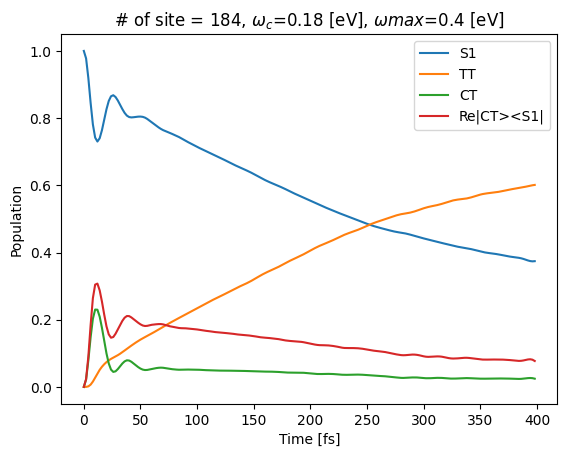

In [17]:
plt.title(f'# of site = {len(basis)}, $ω_c$={ωc} [eV], $ωmax$={ωmax} [eV]')
plt.ylabel('Population')
plt.xlabel('Time [fs]')
plt.plot(time_data, density_data_real[:, 0, 0], label="S1")
plt.plot(time_data, density_data_real[:, 1, 1], label="TT")
plt.plot(time_data, density_data_real[:, 2, 2], label="CT")
plt.plot(time_data, density_data_real[:, 0, 2], label="Re|CT><S1|")
plt.legend()
plt.show()

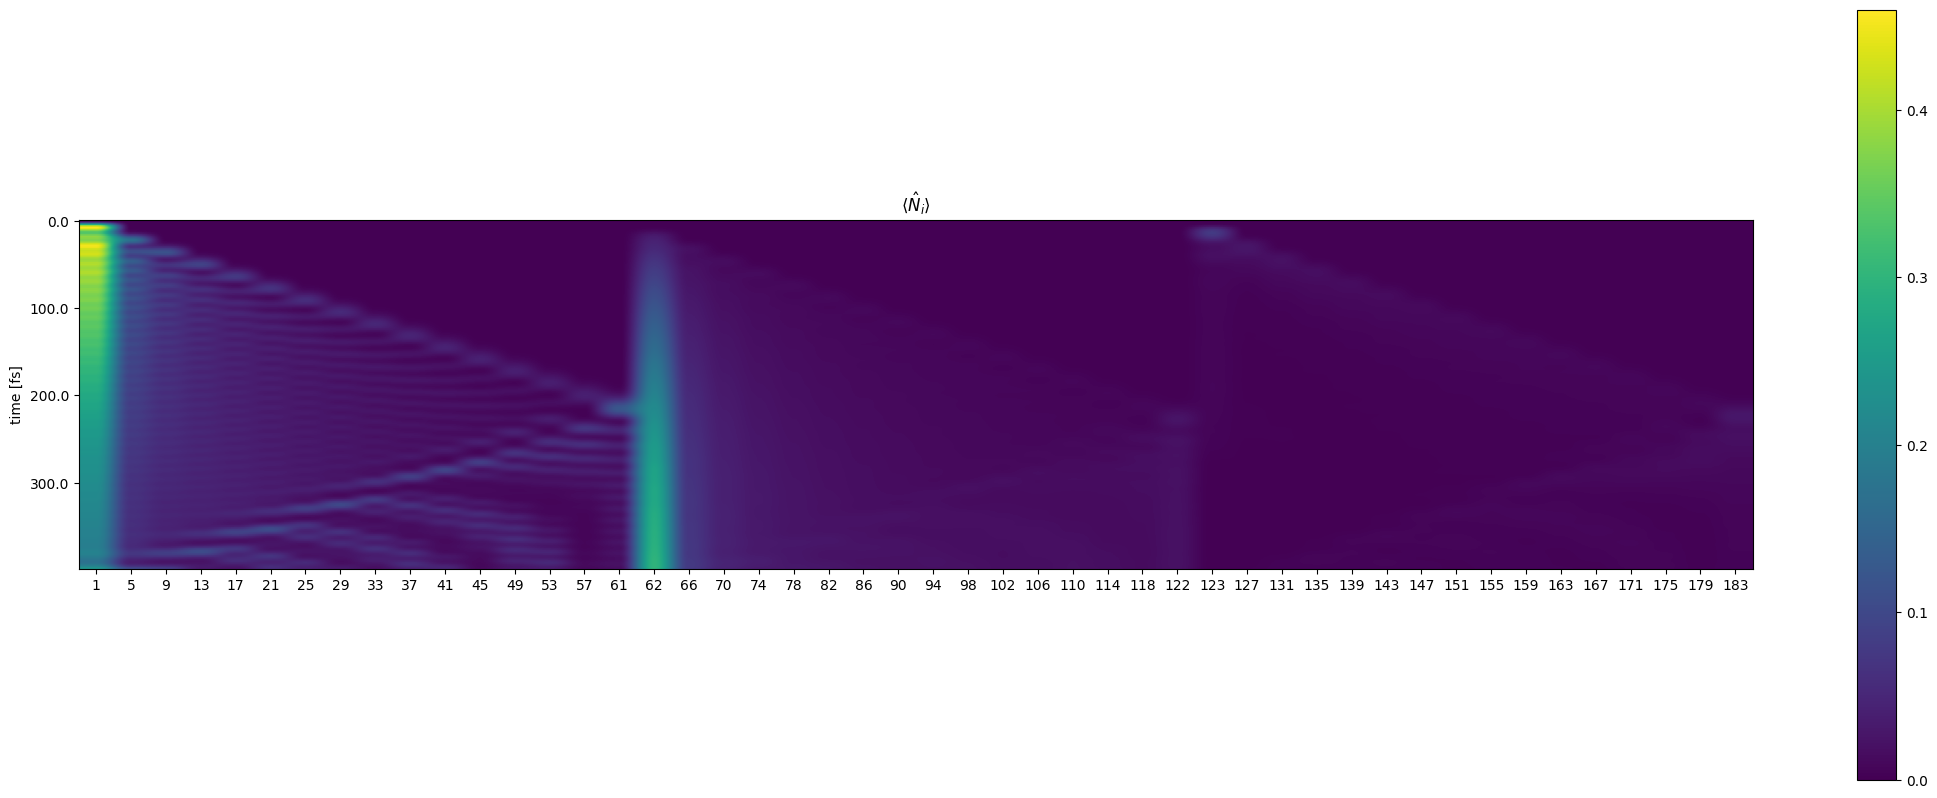

In [22]:
import polars as pl
import re

path = f"{jobname}_prop/expectations.dat"
with open(path, "r") as f:
    header = f.readline().strip()
    columns = re.split(r"\s+", header)
    columns = [columns[1]] + columns[3:]

    data = f.readlines()

df = pl.read_csv(
    path,
    separator="\t",
    new_columns=columns,
    has_header=False,
    skip_rows=1,
    schema_overrides={col: pl.Float64 for col in columns}, 
)
plt.figure(figsize=(27, 10))
plt.imshow(df[columns[2:]], aspect=5.e-02)
plt.colorbar()
plt.ylabel('time [fs]')
plt.yticks(np.arange(len(df))[::50], df['time'][::50])
plt.xticks(np.arange(len(columns)-2), [name[1:] for name in columns[2:]])
plt.title(r'$\langle \hat{N}_i \rangle$')
plt.show()